In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../../src')
import warnings
import gc
warnings.filterwarnings('ignore')

from spaceoracle.prophets import Prophet

In [3]:
adata_train = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
# adata_train = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')

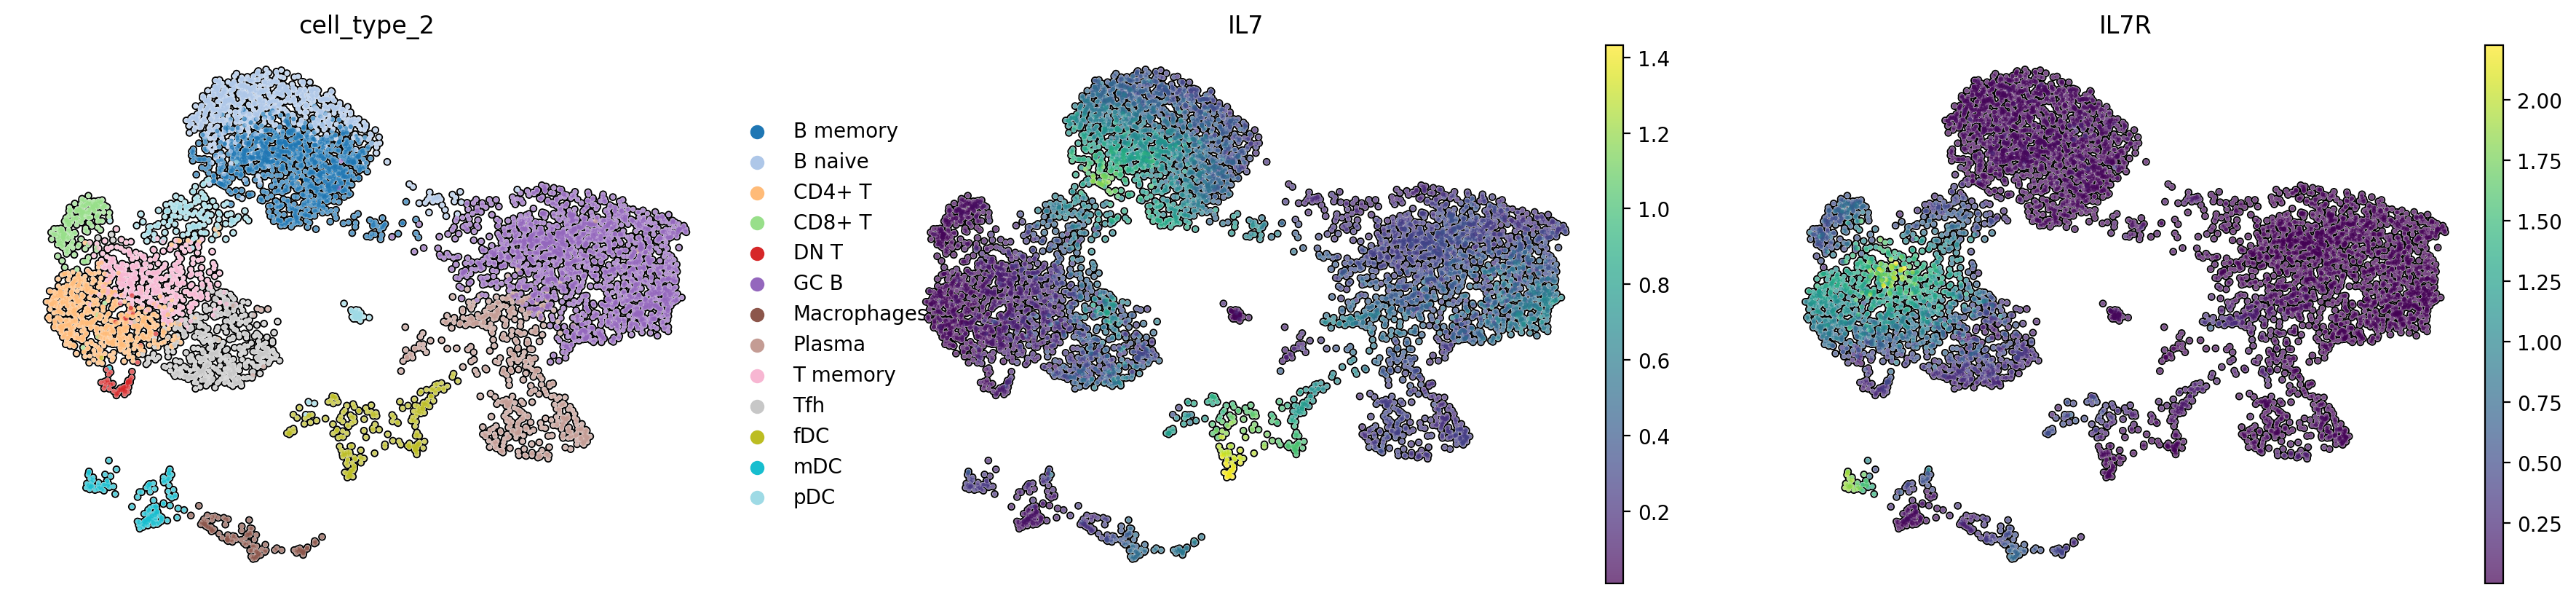

In [109]:
sc.pl.umap(adata_train, color=['cell_type_2', 'IL7', 'IL7R'], frameon=False, add_outline=True, 
        palette='tab20', layer='imputed_count')

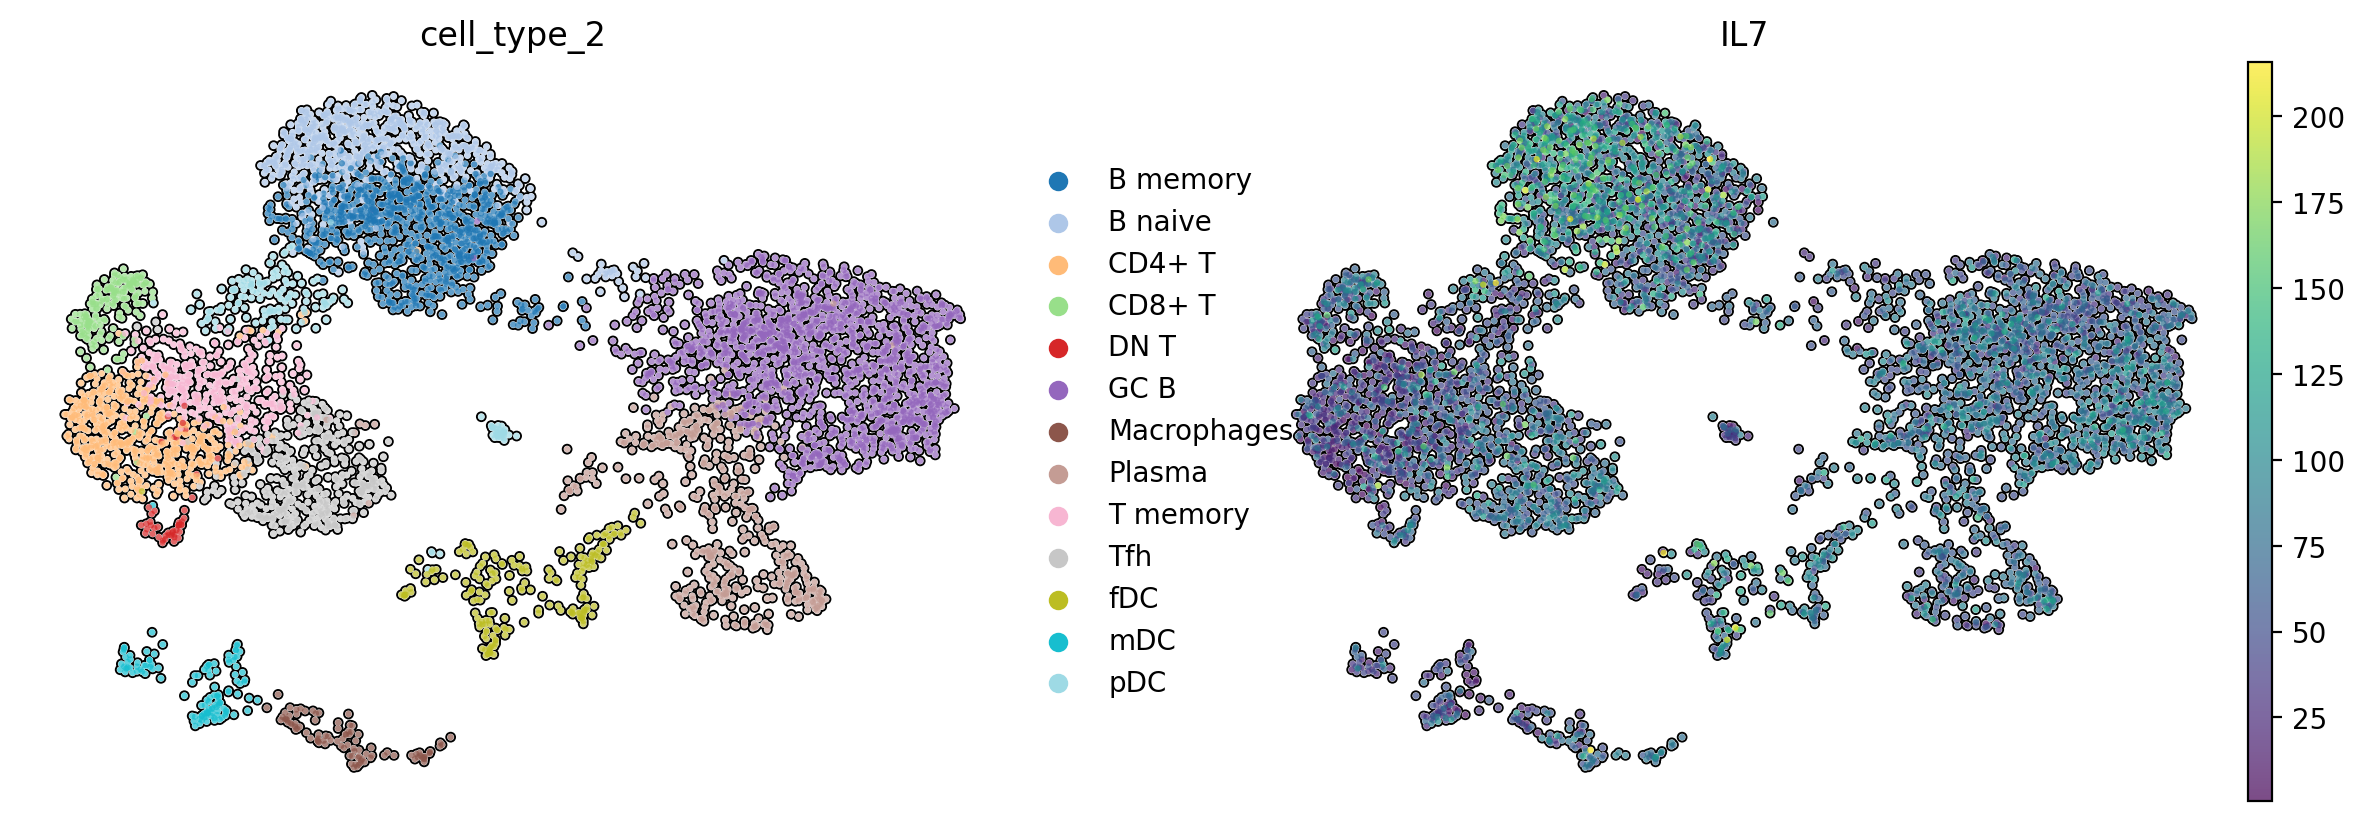

In [107]:
sc.pl.umap(pythia.adata, color=['cell_type_2', 'IL7'], frameon=False, add_outline=True, 
        palette='tab20', layer='received_ligands')

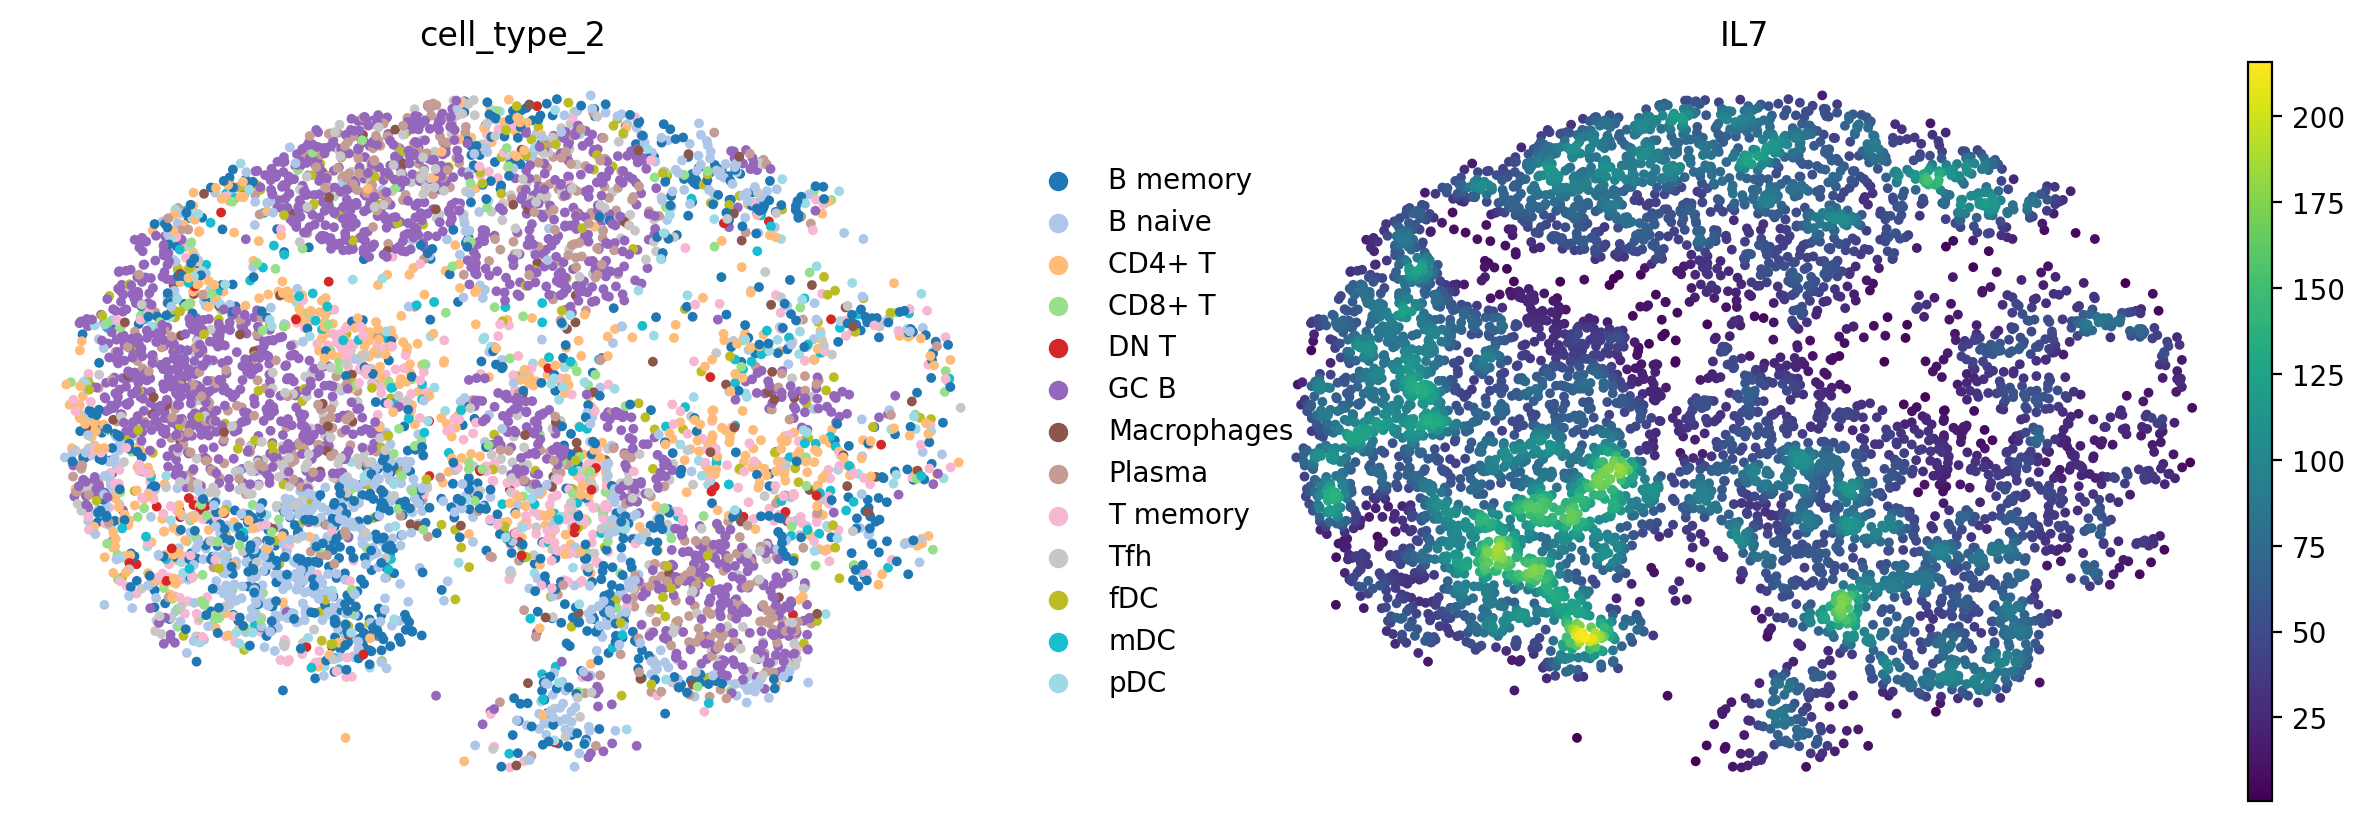

In [114]:
sc.pl.embedding(pythia.adata, basis='spatial',color=['cell_type_2', 'IL7'], frameon=False, add_outline=False, 
        palette='tab20', layer='received_ligands', s=50)

In [102]:
weighted_ligands_0.mean().sort_values(ascending=False)[:10]

Unnamed: 0
ANGPTL1     114.810449
PDGFD       111.822446
IL7          69.429442
WNT5B        36.764687
TNFSF8       34.997921
CXCL13       24.919266
IL18         20.576268
TNFSF13B     20.389464
CCL5         18.104807
IL15         16.788610
dtype: float64

In [108]:
pythia.lr.query('pathway=="IL2"')

ligand receptor pathway           signaling  radius
725    IL4     IL4R     IL2  Secreted Signaling     100
726    IL7     IL7R     IL2  Secreted Signaling     100
728   IL15    IL2RB     IL2  Secreted Signaling     100

In [4]:
# base_dir = '/ix/djishnu/shared/djishnu_kor11/super_filtered_runs'
base_dir = '/Volumes/SSD'

In [5]:
pythia = Prophet(
    adata=adata_train,
    models_dir=f'{base_dir}/human_tonsil_v4',
    annot='cell_type_int',
)

assert len(pythia.queue.remaining_genes) == 0

In [14]:
pythia.compute_betas(subsample=None, float16=True)

100%|██████████| 3393/3393 [00:56<00:00, 60.31it/s]


In [72]:
gene_mtx = pythia.adata.layers['imputed_count']
weighted_ligands_0 = pythia._compute_weighted_ligands(gene_mtx)
weighted_ligands_0 = weighted_ligands_0.reindex(columns=pythia.adata.var_names, fill_value=0)
beta_dict = pythia._get_wbetas_dict(pythia.beta_dict, weighted_ligands_0, gene_mtx)


In [127]:
beta_dict.get('BCL2').get('beta_IL7').min(), beta_dict.get('BCL2').get('beta_IL7').max()

(-0.018785209169763308, 0.04223950960345515)

In [132]:
beta_dict.get('BCL2').get('beta_IL7').to_frame().join(pythia.adata.obs['cell_type_2']).groupby('cell_type_2').mean().sort_values(by='beta_IL7', ascending=False)

beta_IL7
cell_type_2          
B naive      0.003061
pDC          0.002295
CD4+ T       0.002258
Macrophages  0.001637
Tfh          0.001593
mDC          0.001024
CD8+ T       0.000462
fDC          0.000222
GC B         0.000053
Plasma      -0.000188
DN T        -0.000330
B memory    -0.000581
T memory    -0.000585

In [79]:
pythia.lr.query('receptor=="TNFRSF8"')

ligand receptor pathway           signaling  radius
824  TNFSF8  TNFRSF8    CD30  Secreted Signaling     100

In [46]:
propagations = pythia.perturb(
    target='PAX5', 
    n_propagation=5, 
    gene_expr=0,
    cells=[518],
    retain_propagation=True
)

In [47]:
len(propagations)

5

In [48]:
genes = ['MALAT1', 'SAMD12', 'BACH2', 'PAX5', 'MYO1E', 
         'RALGPS2', 'ARHGAP24', 'LHFPL2', 'SPRED2', 'EBF1', 
    #      'SLC9A9', 'KDM2B', 'CR1', 'FTL', 'PRKCH', 'BANK1', 'FMNL2', 'FNDC3A',
    #    'CR2', 'SOX5'
       ]

data = []
for gene in genes:
    values = [pythia.adata.to_df(layer='imputed_count').loc['ACGTAGTCAGTCTCTC-1'][gene]] + [
        pd.DataFrame(propagations[i], 
        index=pythia.adata.obs_names, columns=pythia.adata.var_names).loc[
            'ACGTAGTCAGTCTCTC-1'][gene] for i in range(5)]
    data.append(values)

df = pd.DataFrame(data, index=genes, columns=['Original'] + [f'Step {i}' for i in range(1, 5+1)])

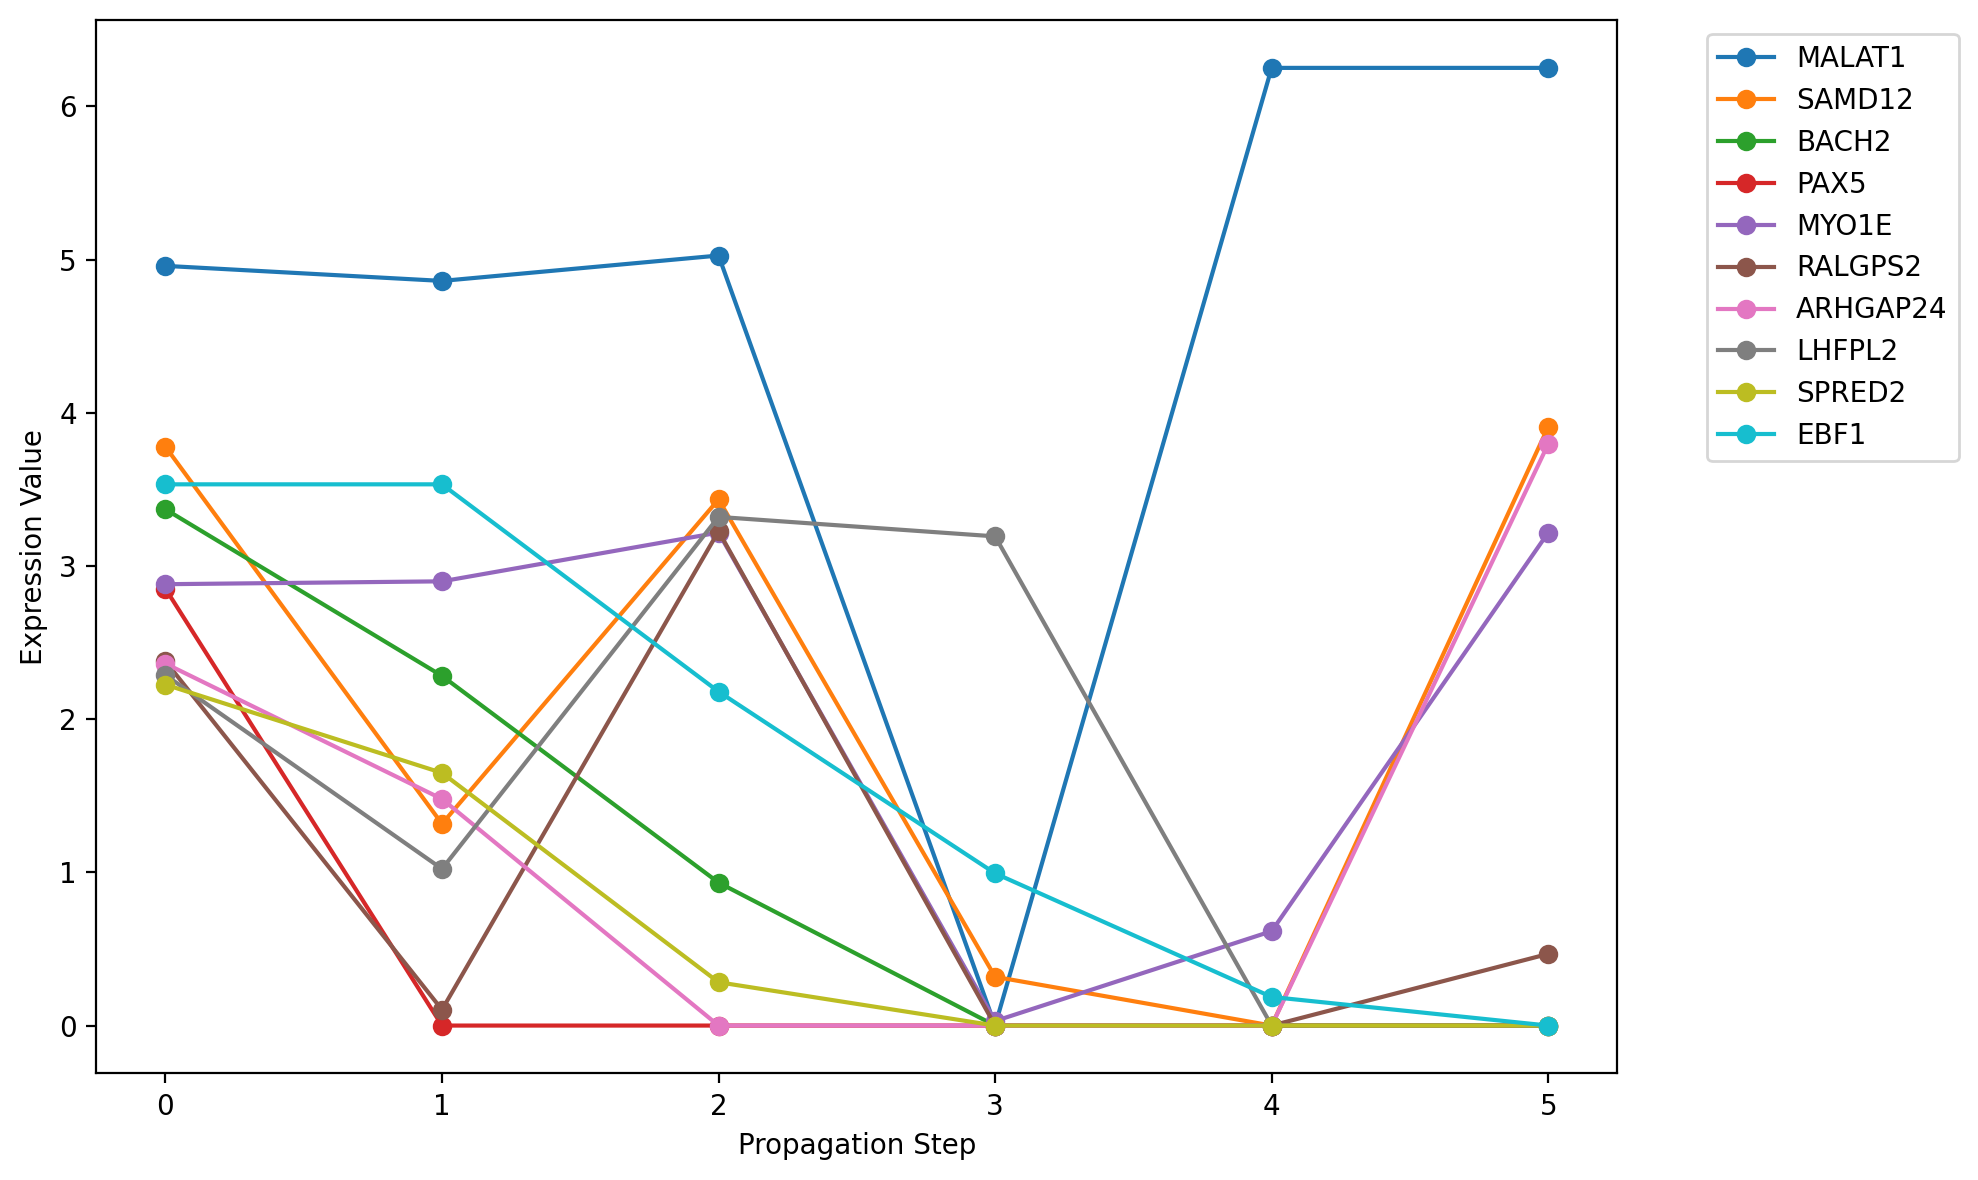

In [49]:
plt.figure(figsize=(10,6))
for gene in genes:
    plt.plot(range(6), df.loc[gene], marker='o', label=gene)
plt.xlabel('Propagation Step')
plt.ylabel('Expression Value') 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [39]:
pd.DataFrame(pythia.adata.to_df(layer='imputed_count')-propagations[0]).loc['ACGTAGTCAGTCTCTC-1'].astype(bool).value_counts()

ACGTAGTCAGTCTCTC-1
True     2734
False     815
Name: count, dtype: int64

In [44]:
pd.DataFrame(pythia.adata.to_df(layer='imputed_count')-propagations[-1]).loc['ACGTAGTCAGTCTCTC-1'].astype(bool).value_counts()

ACGTAGTCAGTCTCTC-1
True     3253
False     296
Name: count, dtype: int64

In [ ]:
# import altair as alt
# import ipywidgets as widgets
# from IPython.display import display
# alt.data_transformers.enable("vegafusion")
# # Get available ligands from the changes1 dataframe
# available_ligands = pythia.ligands
# # Create dropdown widgets for ligand and propagation selection
# ligand_dropdown = widgets.Dropdown(
#     options=available_ligands,
#     value='CD40LG',
#     description='Ligand:',
#     style={'description_width': 'initial'}
# )

# propagation_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(propagations)-1,
#     step=1,
#     description='Propagation:',
#     style={'description_width': 'initial'}
# )

# # Function to compute changes based on selected propagation
# def compute_changes(propagation_idx):
#     baseline = pythia._compute_weighted_ligands(pythia.adata.layers['imputed_count'])
#     perturbed = pythia._compute_weighted_ligands(propagations[propagation_idx])
#     # Calculate percentage change: (new - old) / old * 100
#     return ((perturbed - baseline) / baseline) * 100

# # Initial changes calculation
# changes = compute_changes(1)

# def create_chart(ligand, propagation_idx):
#     # Recalculate changes for the selected propagation
#     changes = compute_changes(propagation_idx)
    
#     plot_data = changes[[ligand]].join(pythia.xy).reset_index()
#     plot_data['cell_index'] = plot_data.index
    
#     # Create a condition for highlighting cell index 518
#     is_target_cell = alt.condition(
#         alt.datum.cell_index == 518,
#         alt.value('red'),
#         alt.value(None)
#     )
    
#     chart = alt.Chart(plot_data).mark_circle(size=100).encode(
#         x='x:Q',
#         y='y:Q',
#         color=alt.Color(f'{ligand}:Q', scale=alt.Scale(scheme='viridis')),
#         stroke=is_target_cell,
#         strokeWidth=alt.condition(
#             alt.datum.cell_index == 518,
#             alt.value(2),
#             alt.value(0)
#         ),
#         tooltip=['NAME', f'{ligand}:Q', 'x:Q', 'y:Q', 'cell_index:Q']
#     ).properties(
#         width=600,
#         height=600
#     ).interactive()
    
#     return chart

# def update_chart(change):
#     with chart_output:
#         chart_output.clear_output(wait=True)
#         display(create_chart(ligand_dropdown.value, propagation_slider.value))

# # Set up the callbacks
# ligand_dropdown.observe(update_chart, names='value')
# propagation_slider.observe(update_chart, names='value')

# # Create output area for the chart
# chart_output = widgets.Output()

# # Create a container for the widgets
# widgets_container = widgets.HBox([ligand_dropdown, propagation_slider])

# # Display the widgets and initial chart
# display(widgets_container)
# with chart_output:
#     display(create_chart(ligand_dropdown.value, propagation_slider.value))
# display(chart_output)

In [150]:
result = None
for ligand in pythia.ligands:
    try:
        df = pythia.beta_dict.data[ligand].wbetas
        if 'beta_PAX5' in df.columns:
            df = df.join(pythia.adata.obs['cell_type'])[['cell_type', 'beta_PAX5']]
            df = df.rename(columns={'beta_PAX5': f'{ligand}_beta_PAX5'})
            if result is None:
                result = df
            else:
                result = result.join(df[f'{ligand}_beta_PAX5'])
    except KeyError:
        continue
if result is not None:
    result.groupby('cell_type').mean()
else:
    print("No beta_PAX5 found in any ligand data")

: 

In [141]:
pythia.lr.query('ligand=="PDGFD"')

ligand receptor pathway           signaling  radius
588  PDGFD   PDGFRB    PDGF  Secreted Signaling     100

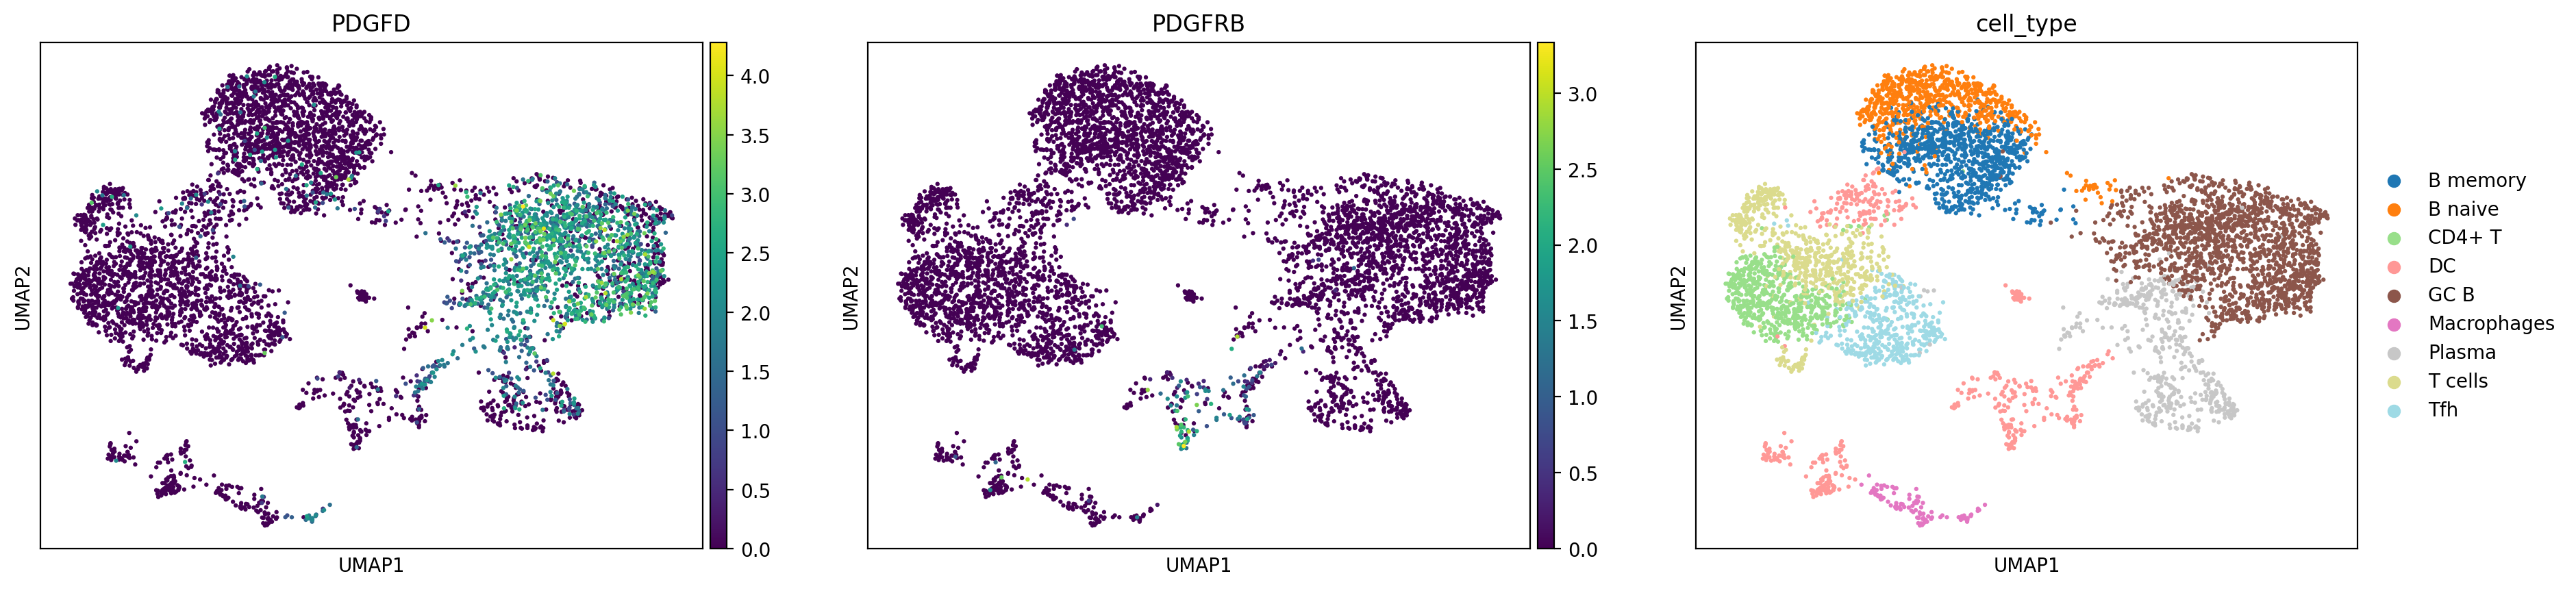

In [145]:
sc.pl.umap(pythia.adata, color=['PDGFD', 'PDGFRB', 'cell_type'])

In [ ]:
pythia.beta_dict.data['PDGFD'].wbetas['beta_PAX5']

In [148]:
pythia.beta_dict.data['PDGFD'].wbetas.mean().sort_values(ascending=False)

beta_IL7R        2.669478
beta_CUX2        2.608572
beta_TNFRSF8     2.546659
beta_FOS         1.040366
beta_MERTK       0.865382
                   ...   
beta_KLF2       -0.666467
beta_SMAD1      -0.794212
beta_PPARGC1A   -0.817048
beta_FZD8       -0.913497
beta_KLF3       -1.453899
Length: 156, dtype: float64

In [138]:
result.groupby('cell_type').mean().mean(0).sort_values(ascending=False)

PDGFD_beta_PAX5       0.168955
IL7_beta_PAX5         0.042387
CCL5_beta_PAX5        0.016309
WNT5B_beta_PAX5       0.012705
EBI3_beta_PAX5        0.008676
SEMA3D_beta_PAX5      0.008034
NRG3_beta_PAX5        0.007712
GZMA_beta_PAX5        0.006039
RARRES2_beta_PAX5     0.005326
GDF7_beta_PAX5        0.004818
TNF_beta_PAX5         0.004481
BMP7_beta_PAX5        0.004309
TNFSF11_beta_PAX5     0.003746
NPPC_beta_PAX5        0.003295
NRG2_beta_PAX5        0.003209
IL33_beta_PAX5        0.002897
CCL20_beta_PAX5       0.001726
CXCL10_beta_PAX5      0.001483
NRG1_beta_PAX5        0.001003
WNT3_beta_PAX5        0.000957
IL34_beta_PAX5        0.000437
CCL2_beta_PAX5        0.000244
CCL4_beta_PAX5        0.000090
CCL3_beta_PAX5       -0.000358
VEGFC_beta_PAX5      -0.000414
WNT10A_beta_PAX5     -0.000930
FLT3LG_beta_PAX5     -0.001217
TNFSF9_beta_PAX5     -0.001340
EDA_beta_PAX5        -0.001407
CCL19_beta_PAX5      -0.001466
IGF1_beta_PAX5       -0.001513
WNT4_beta_PAX5       -0.001555
CXCL12_b

In [126]:
pythia.beta_dict.data['PAX5'].wbetas.join(pythia.adata.obs[
    'cell_type'])[['cell_type', 'beta_IL7']].groupby('cell_type').mean()

beta_IL7
cell_type            
B memory    -0.002042
B naive     -0.000533
CD4+ T      -0.000381
DC          -0.000830
GC B        -0.000132
Macrophages  0.000002
Plasma      -0.000411
T cells     -0.001842
Tfh          0.000128

<Axes: xlabel='x', ylabel='y'>

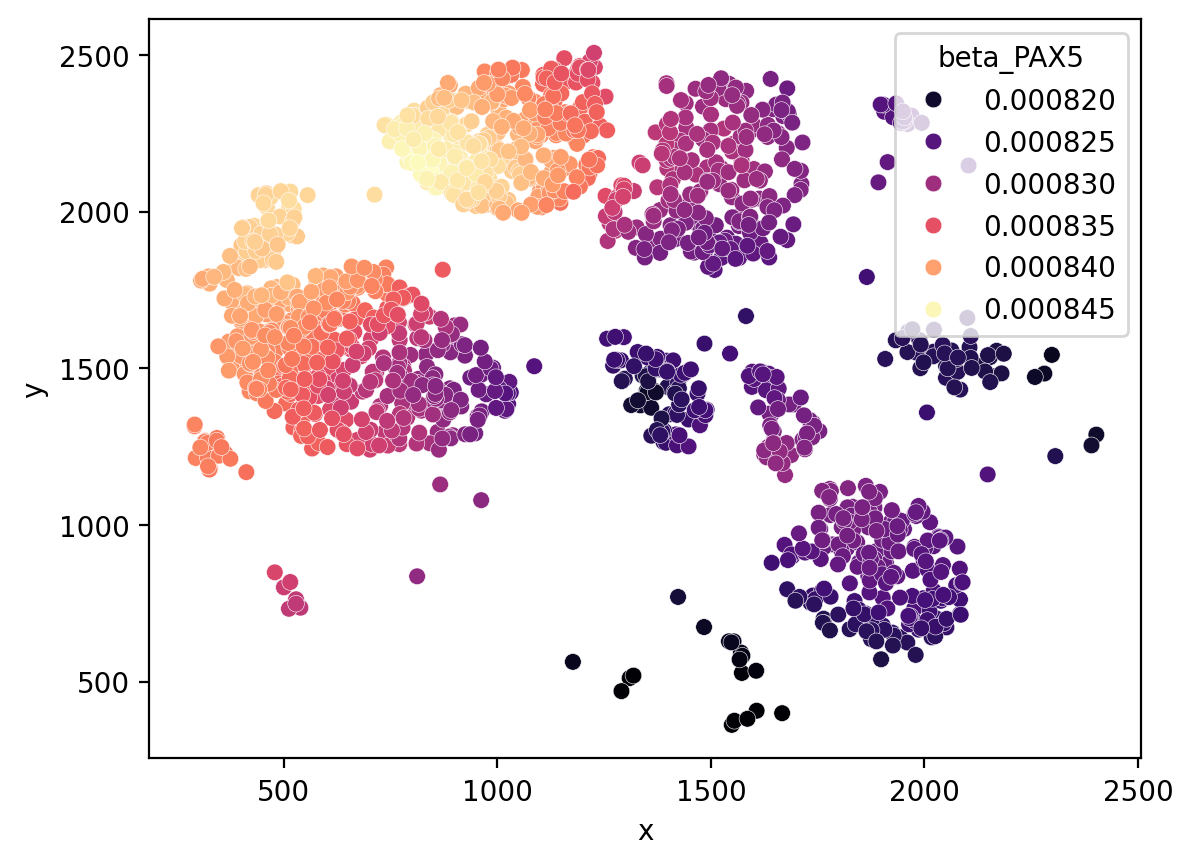

In [124]:
sns.scatterplot(
    data=pythia.beta_dict.data['IL7'].wbetas.join(
        pythia.xy).join(pythia.adata.obs['cell_type']).query('cell_type=="GC B"'),
    x='x', y='y',
    hue='beta_PAX5',
    palette='magma',
    linewidth=0.2)

In [29]:
(pythia.adata.to_df(layer='PAX5_1n_0x') - pythia.adata.to_df(layer='imputed_count')).iloc[518].loc['IL7']

-0.002388825745679779

In [21]:
# df1 = pythia.beta_dict.data['PAX5'].wbetas.copy()
df2 = pythia.beta_dict.data['PAX5'].wbetas.copy()

In [29]:
import numpy as np

In [30]:
np.unique(pythia.beta_dict.data['PAX5'].ligands)

array(['ANGPTL1', 'ANXA1', 'BMP6', 'BMP7', 'BMP8A', 'C3', 'CCL19', 'CCL2',
       'CCL20', 'CCL21', 'CCL3', 'CCL4', 'CCL5', 'CD40LG', 'CSF1',
       'CXCL10', 'CXCL12', 'CXCL13', 'CXCL16', 'CXCL9', 'EBI3', 'EDA',
       'FGF7', 'FLT3LG', 'GAS6', 'GDF7', 'GZMA', 'IGF1', 'IL15', 'IL18',
       'IL33', 'IL34', 'IL4', 'IL6', 'IL7', 'KITLG', 'NPPC', 'NRG1',
       'NRG2', 'NRG3', 'PDGFD', 'RARRES2', 'SEMA3A', 'SEMA3C', 'SEMA3D',
       'TAC4', 'TNF', 'TNFSF11', 'TNFSF13B', 'TNFSF8', 'TNFSF9', 'VEGFC',
       'WNT10A', 'WNT10B', 'WNT3', 'WNT4', 'WNT5B'], dtype='<U8')

In [63]:
rename = lambda df: df.rename(columns=lambda x: x.replace('beta_', '')) if df is not None else df

In [82]:
pythia.adata.to_df(layer='imputed_count')['IL7'].mean()

0.38139059482151383

In [84]:
pythia.adata.to_df(layer='PAX5_1n_0x')['IL7'].mean()

0.3467231614089001

<Axes: ylabel='Frequency'>

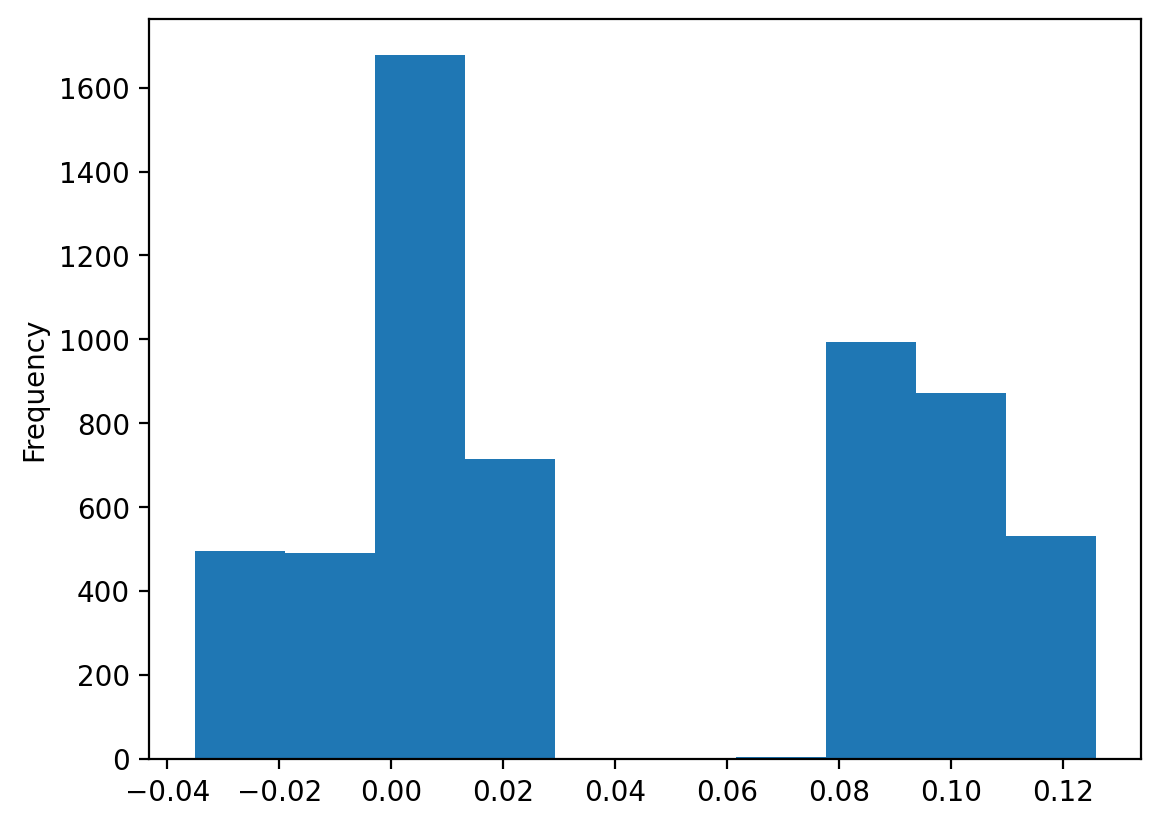

In [86]:
pythia.beta_dict.data['IL7'].wbetas.get('beta_PAX5').plot.hist()

<Axes: ylabel='Frequency'>

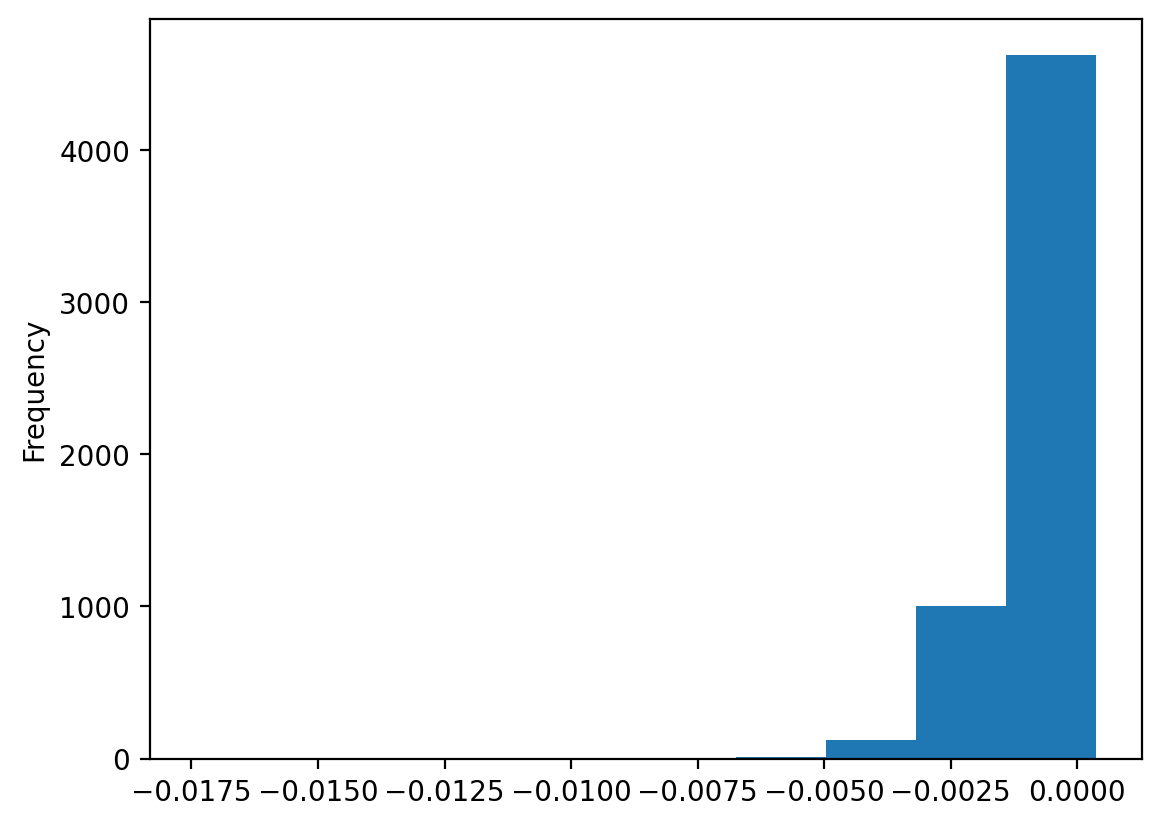

In [85]:
pythia.beta_dict.data['PAX5'].wbetas.get('beta_IL7').plot.hist()

In [68]:
meta = [(i, pythia.beta_dict.data[i].wbetas.get('beta_PAX5')) for 
    i in np.unique(pythia.beta_dict.data['PAX5'].ligands) if i in pythia.beta_dict.data.keys()]

In [73]:
dfpax = pd.concat([item[1] for item in meta if item[1] is not None], axis=1)
dfpax.columns = [item[0] for item in meta if item[1] is not None]

In [75]:
dfpax.mean().sort_values(ascending=False)

PDGFD       0.258910
IL7         0.040724
WNT5B       0.037707
CCL5        0.011979
SEMA3D      0.008444
NRG3        0.006855
GZMA        0.005368
TNF         0.005223
TNFSF11     0.005065
GDF7        0.004436
RARRES2     0.003632
BMP7        0.003129
NPPC        0.002951
NRG2        0.002464
IL33        0.002222
EBI3        0.001780
CCL20       0.001630
WNT3        0.001179
IL34        0.000286
CXCL10      0.000283
CCL2        0.000201
NRG1       -0.000379
VEGFC      -0.000517
WNT10A     -0.000627
CCL3       -0.001064
CCL4       -0.001078
TNFSF9     -0.001108
FLT3LG     -0.001163
EDA        -0.001427
CXCL12     -0.001427
WNT10B     -0.002024
IGF1       -0.002040
CSF1       -0.002326
BMP8A      -0.002629
CCL19      -0.002677
WNT4       -0.002957
SEMA3C     -0.004647
CCL21      -0.005285
SEMA3A     -0.007012
TNFSF13B   -0.011046
BMP6       -0.011345
KITLG      -0.011688
IL15       -0.014745
GAS6       -0.035464
dtype: float64

In [67]:
dfpax.columns = [i for i in np.unique(pythia.beta_dict.data['PAX5'].ligands) if i in pythia.beta_dict.data.keys()]

ValueError: Length mismatch: Expected axis has 44 elements, new values have 56 elements

In [57]:
dfpax

beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  \
NAME                                                                        
AAACCCAAGCGCCTTG-1   0.002544   0.002108   0.005146   0.007308  -0.000032   
AAACCCAAGTGGACGT-1  -0.081273   0.012573  -0.001450   0.003060   0.000262   
AAACCCACAGAAGTGC-1  -0.013675  -0.001381  -0.002051  -0.005765   0.000000   
AAACCCAGTCATTGCA-1   0.000257   0.005143  -0.036906  -0.003472   0.002146   
AAACCCATCATCGCAA-1  -0.003152  -0.001950   0.001470  -0.003979   0.000000   
...                       ...        ...        ...        ...        ...   
TTTGTTGCAGGGACTA-1  -0.014305  -0.001448  -0.002267  -0.005562   0.000000   
TTTGTTGCATTGTAGC-1  -0.081171   0.013062  -0.001404   0.003061   0.000266   
TTTGTTGGTACCACGC-1  -0.013336  -0.001384  -0.002242  -0.005487   0.000000   
TTTGTTGGTCTGTCCT-1   0.000300   0.013390   0.000564   0.000114   0.000000   
TTTGTTGTCATGCGGC-1   0.000301   0.013059   0.000554   0.000100   0.000000   

                    beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  \
NAME                                                                        
AAACCCAAGCGCCTTG-1   0.008125   0.010433   0.002091   0.010825   0.161389   
AAACCCAAGTGGACGT-1  -0.000048   0.004277  -0.000766   0.001158   0.007191   
AAACCCACAGAAGTGC-1   0.000289  -0.004318  -0.003285  -0.003223  -0.009328   
AAACCCAGTCATTGCA-1   0.002854  -0.058351  -0.000219   0.004938   0.018065   
AAACCCATCATCGCAA-1   0.001830  -0.000969  -0.000420  -0.005773  -0.011277   
...                       ...        ...        ...        ...        ...   
TTTGTTGCAGGGACTA-1   0.000290  -0.004321  -0.003200  -0.003325  -0.009730   
TTTGTTGCATTGTAGC-1  -0.000051   0.004383  -0.000798   0.001143   0.007223   
TTTGTTGGTACCACGC-1   0.000292  -0.004296  -0.003632  -0.003283  -0.009417   
TTTGTTGGTCTGTCCT-1   0.000288  -0.000044   0.001052   0.002198  -0.001153   
TTTGTTGTCATGCGGC-1   0.000318  -0.000043   0.001013   0.002230  -0.001122   

                    ...  beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  \
NAME                ...                                               
AAACCCAAGCGCCTTG-1  ...   0.000265   0.005739  -0.019017  -0.012496   
AAACCCAAGTGGACGT-1  ...   0.002703   0.011654  -0.007640  -0.000016   
AAACCCACAGAAGTGC-1  ...   0.006009   0.009904  -0.032630   0.000837   
AAACCCAGTCATTGCA-1  ...   0.013457   0.002856  -0.022036   0.000166   
AAACCCATCATCGCAA-1  ...   0.011516   0.004983   0.007484  -0.000207   
...                 ...        ...        ...        ...        ...   
TTTGTTGCAGGGACTA-1  ...   0.006264   0.009844  -0.034031   0.000895   
TTTGTTGCATTGTAGC-1  ...   0.002703   0.011874  -0.007837  -0.000016   
TTTGTTGGTACCACGC-1  ...   0.006326   0.009962  -0.031751   0.000756   
TTTGTTGGTCTGTCCT-1  ...   0.000421   0.000441  -0.001380  -0.000109   
TTTGTTGTCATGCGGC-1  ...   0.000412   0.000442  -0.001304  -0.000112   

                    beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  beta_PAX5  \
NAME                                                                        
AAACCCAAGCGCCTTG-1   0.000694   0.001537  -0.000122  -0.000752   0.000436   
AAACCCAAGTGGACGT-1   0.000154  -0.000181  -0.019196   0.000546  -0.002124   
AAACCCACAGAAGTGC-1  -0.000864   0.000533  -0.001479   0.001521  -0.008136   
AAACCCAGTCATTGCA-1  -0.003357  -0.009694   0.000661   0.002858   0.000449   
AAACCCATCATCGCAA-1  -0.000023  -0.000265  -0.000038   0.000739  -0.002842   
...                       ...        ...        ...        ...        ...   
TTTGTTGCAGGGACTA-1  -0.000868   0.000560  -0.001608   0.001568  -0.008221   
TTTGTTGCATTGTAGC-1   0.000150  -0.000180  -0.019036   0.000537  -0.002035   
TTTGTTGGTACCACGC-1  -0.000858   0.000538  -0.001502   0.001548  -0.008246   
TTTGTTGGTCTGTCCT-1   0.000251   0.000028  -0.000395  -0.000077  -0.000043   
TTTGTTGTCATGCGGC-1   0.000244   0.000028  -0.000381  -0.000084  -0.000047   

                    beta_PAX5  
NAME                           
AAACCCAAGCGCCTTG-1   0.007

In [15]:
from glob import glob
import numpy as np

In [13]:
glob('/tmp/perturbations/*')

['/tmp/perturbations/PAX5_7n_0x.npy',
 '/tmp/perturbations/PAX5_6n_0x.npy',
 '/tmp/perturbations/PAX5_4n_0x.npy',
 '/tmp/perturbations/PAX5_5n_0x.npy',
 '/tmp/perturbations/PAX5_0n_0x.npy',
 '/tmp/perturbations/PAX5_9n_0x.npy',
 '/tmp/perturbations/PAX5_8n_0x.npy',
 '/tmp/perturbations/PAX5_1n_0x.npy',
 '/tmp/perturbations/PAX5_3n_0x.npy',
 '/tmp/perturbations/PAX5_2n_0x.npy']

In [22]:
pd.DataFrame(pythia.adata.layers['imputed_count'], index=pythia.adata.obs.index, columns=pythia.adata.var_names)

Unnamed: 0            FAM41C   PLEKHN1   TNFRSF4    SCNN1D    INTS11  \
NAME                                                                   
AAACCCAAGCGCCTTG-1  0.007221  0.014181  0.036335  0.001485  0.131678   
AAACCCAAGTGGACGT-1  0.000658  0.058546  0.009818  0.000026  0.228833   
AAACCCACAGAAGTGC-1  0.000443  0.002875  0.001127  0.003330  0.143343   
AAACCCAGTCATTGCA-1  0.009217  0.004287  0.044471  0.001047  0.138716   
AAACCCATCATCGCAA-1  0.001308  0.000803  0.002003  0.039152  0.084113   
...                      ...       ...       ...       ...       ...   
TTTGTTGCAGGGACTA-1  0.000512  0.000114  0.000969  0.000839  0.209704   
TTTGTTGCATTGTAGC-1  0.000787  0.050118  0.001364  0.000000  0.072072   
TTTGTTGGTACCACGC-1  0.000197  0.000079  0.000581  0.000320  0.179348   
TTTGTTGGTCTGTCCT-1  0.006844  0.006935  0.016407  0.000336  0.080520   
TTTGTTGTCATGCGGC-1  0.004802  0.002590  0.017735  0.001091  0.097051   

Unnamed: 0            ATAD3C       SKI     PEX10     PLCH2    PRXL2B  ...  \
NAME                                                                  ...   
AAACCCAAGCGCCTTG-1  0.002217  0.507714  0.027004  0.065194  0.066746  ...   
AAACCCAAGTGGACGT-1  0.017483  0.081871  0.089802  0.008087  0.012313  ...   
AAACCCACAGAAGTGC-1  0.000164  0.057640  0.085894  0.001813  0.005656  ...   
AAACCCAGTCATTGCA-1  0.008981  0.576189  0.068743  0.026675  0.029116  ...   
AAACCCATCATCGCAA-1  0.001551  0.358982  0.024852  0.044741  0.035593  ...   
...                      ...       ...       ...       ...       ...  ...   
TTTGTTGCAGGGACTA-1  0.000285  0.069881  0.097712  0.004956  0.030194  ...   
TTTGTTGCATTGTAGC-1  0.000592  0.122777  0.021221  0.000076  0.049611  ...   
TTTGTTGGTACCACGC-1  0.000200  0.080663  0.065346  0.010893  0.019562  ...   
TTTGTTGGTCTGTCCT-1  0.004205  0.570978  0.031358  0.041282  0.030190  ...   
TTTGTTGTCATGCGGC-1  0.004640  0.407025  0.017416  0.047349  0.018246  ...   

Unnamed: 0            ZNF275     RENBP      FLNA      GAB3      MPP1  \
NAME                                                                   
AAACCCAAGCGCCTTG-1  0.075513  0.018478  0.293790  0.113429  0.002799   
AAACCCAAGTGGACGT-1  0.263240  0.006300  0.171869  0.049101  0.041279   
AAACCCACAGAAGTGC-1  0.040895  0.005318  0.179441  0.017422  0.010408   
AAACCCAGTCATTGCA-1  0.081664  0.037240  0.424322  0.214028  0.032586   
AAACCCATCATCGCAA-1  0.077975  0.033678  0.209385  0.109138  0.005770   
...                      ...       ...       ...       ...       ...   
TTTGTTGCAGGGACTA-1  0.037261  0.014638  0.139541  0.052742  0.011806   
TTTGTTGCATTGTAGC-1  0.296504  0.019607  0.101302  0.065253  0.023472   
TTTGTTGGTACCACGC-1  0.048137  0.012608  0.124711  0.066084  0.008337   
TTTGTTGGTCTGTCCT-1  0.051856  0.014354  0.279193  0.064671  0.046405   
TTTGTTGTCATGCGGC-1  0.053233  0.016273  0.150852  0.074022  0.035640   

Unnamed: 0                F8      F8A1     CLIC2   PCDH11Y    NLGN4Y  
NAME                                                                  
AAACCCAAGCGCCTTG-1  0.027117  0.002652  0.000407  0.004325  0.040839  
AAACCCAAGTGGACGT-1  0.011695  0.032295  0.020307  0.000154  0.324796  
AAACCCACAGAAGTGC-1  0.034698  0.014021  0.001393  0.000114  0.254450  
AAACCCAGTCATTGCA-1  0.020338  0.015003  0.010782  0.003339  0.200644  
AAACCCATCATCGCAA-1  0.003126  0.003415  0.000763  0.000000  0.152485  
...                      ...       ...       ...       ...       ...  
TTTGTTGCAGGGACTA-1  0.028719  0.012644  0.001094  0.000000  0.376674  
TTTGTTGCATTGTAGC-1  0.029412  0.032915  0.067902  0.000000  0.066865  
TTTGTTGGTACCACGC-1  0.030673  0.022541  0.000421  0.000000  0.421316  
TTTGTTGGTCTGTCCT-1  0.012558  0.006849  0.000321  0.000530  0.039131  
TTTGTTGTCATGCGGC-1  0.008475  0.010207  0.001693  0.000044  0.042485  

[5778 rows x 3549 columns]

In [27]:
glob('/tmp/perturbations/*')

['/tmp/perturbations/PAX5_7n_0x.npy',
 '/tmp/perturbations/PAX5_6n_0x.npy',
 '/tmp/perturbations/PAX5_4n_0x.npy',
 '/tmp/perturbations/PAX5_5n_0x.npy',
 '/tmp/perturbations/PAX5_0n_0x.npy',
 '/tmp/perturbations/PAX5_9n_0x.npy',
 '/tmp/perturbations/PAX5_8n_0x.npy',
 '/tmp/perturbations/PAX5_1n_0x.npy',
 '/tmp/perturbations/PAX5_3n_0x.npy',
 '/tmp/perturbations/PAX5_2n_0x.npy']

In [154]:
for i in range(10):
    pythia.adata.layers[f'PAX5_iter_{i}'] = pythia.adata.layers['imputed_count'] + np.load(f'/tmp/perturbations/PAX5_{i}n_0x.npy')

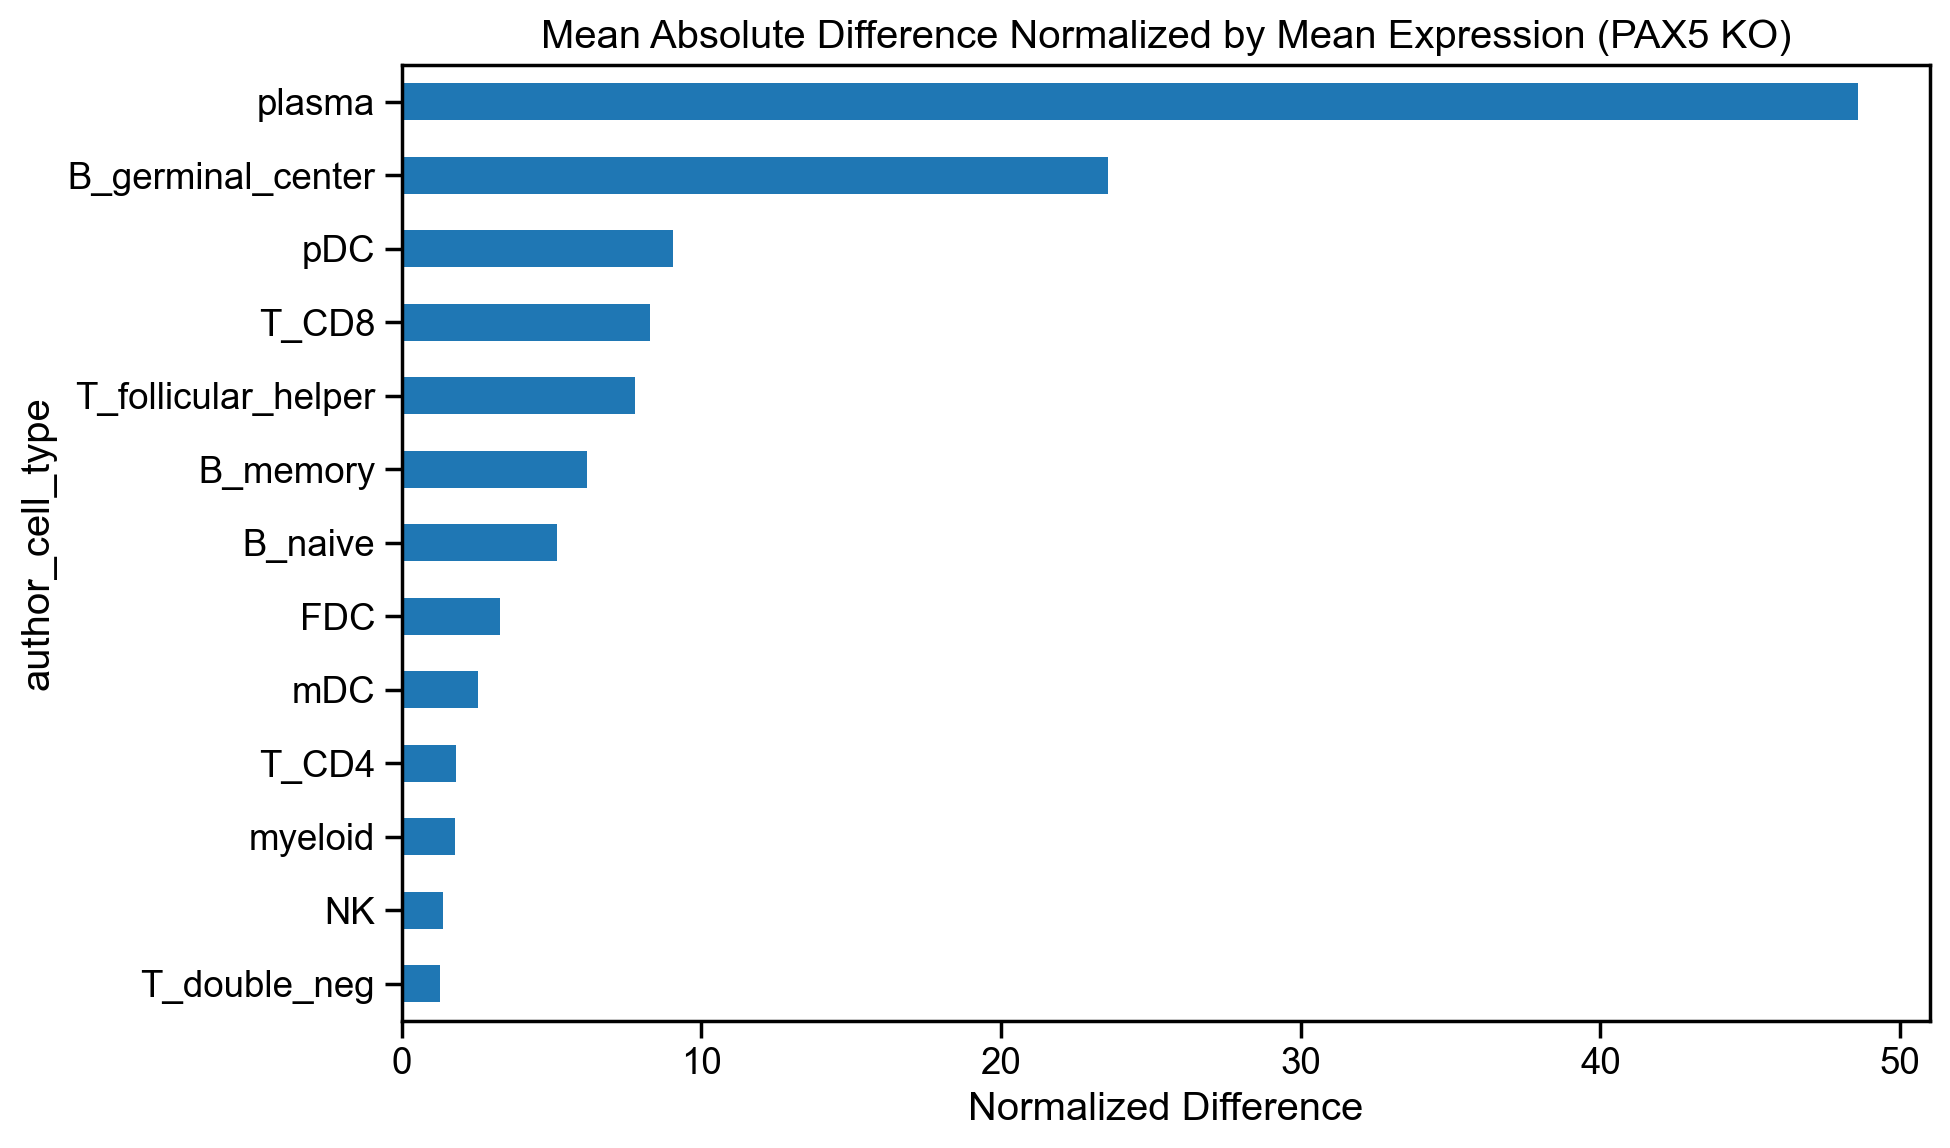

In [171]:
import matplotlib.pyplot as plt

# Calculate the difference between imputed and perturbed expression
diff_df = (pythia.adata.to_df(layer='imputed_count') - pythia.adata.to_df(layer=f'PAX5_iter_4'))

# Get the mean expression values for normalization
mean_expr = pythia.adata.to_df(layer='imputed_count').join(
    pythia.adata.obs['author_cell_type']).groupby('author_cell_type').mean()

# Join with cell type information
diff_with_celltype = diff_df.join(pythia.adata.obs['author_cell_type'])

# Group by cell type, calculate mean, normalize by the mean expression, and handle infinities
normalized_diff = (diff_with_celltype.groupby('author_cell_type').mean().abs() / mean_expr).replace([np.inf, np.nan], 0)

# Calculate the mean across all genes and sort
normalized_diff.mean(axis=1).sort_values(ascending=True).plot.barh(figsize=(10, 6))
plt.title('Mean Absolute Difference Normalized by Mean Expression (PAX5 KO)')
plt.xlabel('Normalized Difference')
plt.tight_layout()

In [169]:
((pythia.adata.to_df(layer='imputed_count'))).join(
    pythia.adata.obs['author_cell_type']).groupby(
    'author_cell_type').mean().abs().mean(axis=1)

author_cell_type
B_germinal_center      0.101164
B_memory               0.114050
B_naive                0.101564
FDC                    0.210133
NK                     0.140848
T_CD4                  0.120936
T_CD8                  0.125924
T_double_neg           0.135838
T_follicular_helper    0.125376
mDC                    0.151587
myeloid                0.204301
pDC                    0.130618
plasma                 0.116879
dtype: float64

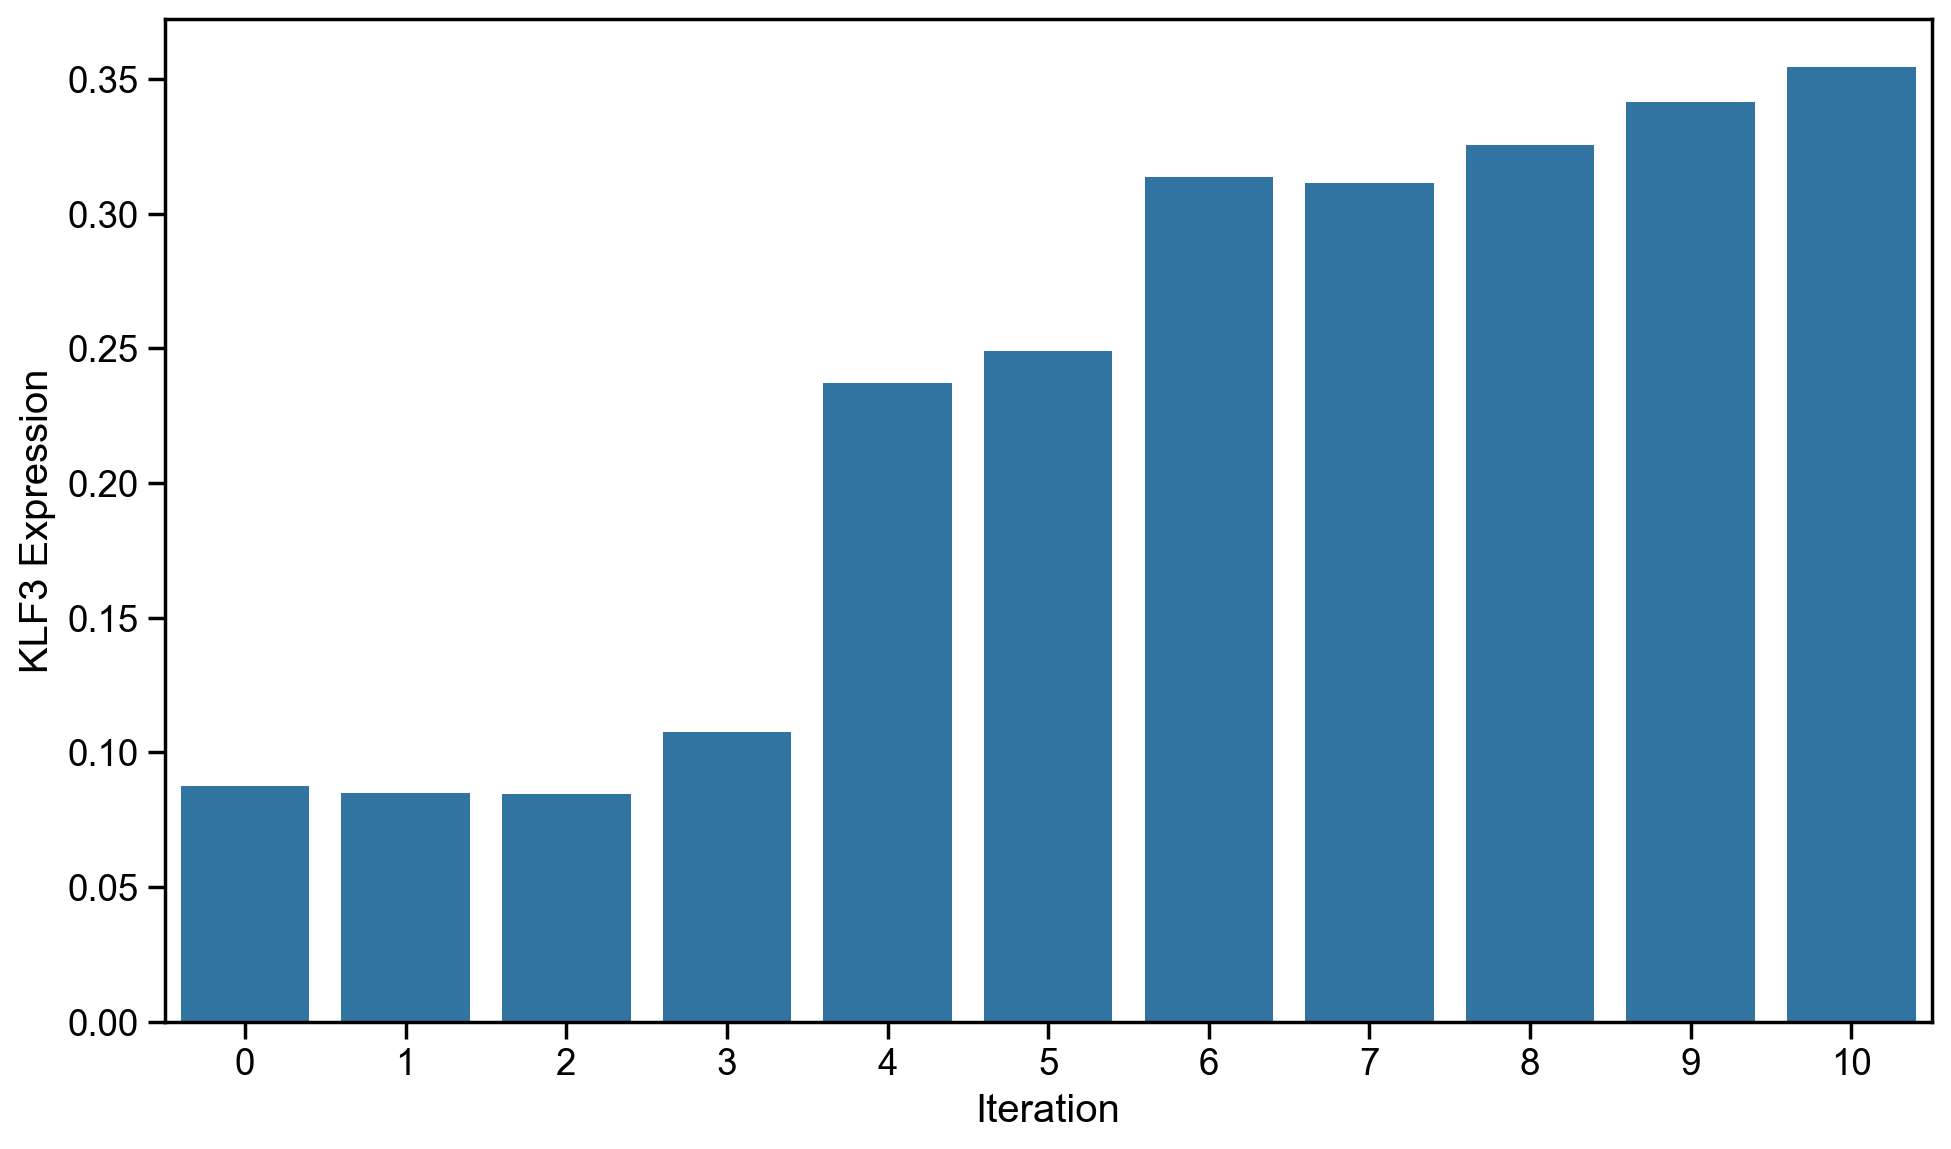

In [107]:
def create_gene_expression_iterations_df(pythia, gene='IL7R', perturbed_gene='PAX5', n_iterations=10):
    """
    Create a DataFrame with gene expression values across perturbation iterations.
    
    Parameters:
    -----------
    pythia : Pythia object
        The Pythia object containing the AnnData
    gene : str
        The gene whose expression to track (default: 'IL7R')
    perturbed_gene : str
        The gene that was perturbed (default: 'PAX5')
    n_iterations : int
        Number of iterations to include (default: 10)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with iteration numbers and gene expression values
    """
    # Create a list to store gene expression values for each iteration
    gene_values = []
    
    # Get baseline expression
    gene_mean = pythia.adata.to_df(layer='imputed_count')[[gene]].mean().values[0]
    gene_values.append(gene_mean)
    
    # Get expression for each iteration
    for i in range(n_iterations):
        gene_mean = pythia.adata.to_df(layer=f'{perturbed_gene}_iter_{i}')[[gene]].mean().values[0]
        gene_values.append(gene_mean)
    
    # Create a DataFrame for plotting
    iterations_df = pd.DataFrame({
        'Iteration': range(n_iterations + 1),
        f'{gene} Expression': gene_values
    })
    
    return iterations_df

gene = 'KLF3'
iterations_df = create_gene_expression_iterations_df(
    pythia, gene=gene, perturbed_gene='PAX5', n_iterations=10)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Iteration', y=f'{gene} Expression', data=iterations_df)
plt.tight_layout()
plt.show()

In [90]:
pythia.adata.to_df(layer='imputed_count')[['IL7R']].mean()

Unnamed: 0
IL7R    0.274754
dtype: float64

In [200]:
pythia.adata.to_df(layer='PAX5_iter_0')-pythia.adata.to_df(layer='imputed_count')

Unnamed: 0          FAM41C   PLEKHN1   TNFRSF4    SCNN1D        INTS11  \
NAME                                                                     
AAACCCAAGCGCCTTG-1     0.0  0.000009 -0.000137  0.000043 -1.715082e-04   
AAACCCAAGTGGACGT-1     0.0  0.026543  0.000052  0.000167 -1.212643e-01   
AAACCCACAGAAGTGC-1     0.0 -0.002875  0.000028 -0.002173 -1.433432e-01   
AAACCCAGTCATTGCA-1     0.0 -0.000282 -0.006701 -0.001044 -3.180250e-02   
AAACCCATCATCGCAA-1     0.0  0.000310  0.000001  0.001738  9.456502e-04   
...                    ...       ...       ...       ...           ...   
TTTGTTGCAGGGACTA-1     0.0 -0.000114  0.000034 -0.000839 -2.097042e-01   
TTTGTTGCATTGTAGC-1     0.0  0.007968  0.000016  0.000051 -3.811101e-02   
TTTGTTGGTACCACGC-1     0.0 -0.000079  0.000031 -0.000320 -1.793482e-01   
TTTGTTGGTCTGTCCT-1     0.0  0.000005  0.000007  0.000006 -1.460743e-06   
TTTGTTGTCATGCGGC-1     0.0  0.000003  0.000003  0.000003 -8.381710e-07   

Unnamed: 0            ATAD3C       SKI     PEX10     PLCH2    PRXL2B  ...  \
NAME                                                                  ...   
AAACCCAAGCGCCTTG-1 -0.000010  0.001644 -0.000132 -0.000015  0.000022  ...   
AAACCCAAGTGGACGT-1 -0.011401 -0.025036 -0.026702 -0.006039 -0.002897  ...   
AAACCCACAGAAGTGC-1  0.000604 -0.057640 -0.008418 -0.001813 -0.005656  ...   
AAACCCAGTCATTGCA-1 -0.002682 -0.278842 -0.011388 -0.003138 -0.000002  ...   
AAACCCATCATCGCAA-1 -0.000939 -0.153861 -0.014619 -0.000386 -0.007093  ...   
...                      ...       ...       ...       ...       ...  ...   
TTTGTTGCAGGGACTA-1  0.000772 -0.069881 -0.010084 -0.004956 -0.030194  ...   
TTTGTTGCATTGTAGC-1 -0.000592 -0.007655 -0.008235 -0.000076 -0.000883  ...   
TTTGTTGGTACCACGC-1  0.000718 -0.080663 -0.009868 -0.010893 -0.019562  ...   
TTTGTTGGTCTGTCCT-1  0.000002 -0.001784 -0.000017  0.000006  0.000016  ...   
TTTGTTGTCATGCGGC-1  0.000001 -0.001025 -0.000009  0.000004  0.000009  ...   

Unnamed: 0            ZNF275     RENBP      FLNA      GAB3          MPP1  \
NAME                                                                       
AAACCCAAGCGCCTTG-1  0.000051 -0.000206 -0.013152  0.001684 -5.023419e-04   
AAACCCAAGTGGACGT-1  0.100959  0.002594 -0.098134 -0.017223 -3.925777e-03   
AAACCCACAGAAGTGC-1  0.042908 -0.005318  0.038829  0.030102 -1.040760e-02   
AAACCCAGTCATTGCA-1 -0.065109  0.001114 -0.053487  0.657904 -1.494351e-03   
AAACCCATCATCGCAA-1  0.001759 -0.017942  0.013637 -0.048270 -5.769934e-03   
...                      ...       ...       ...       ...           ...   
TTTGTTGCAGGGACTA-1  0.054346 -0.008271  0.049054  0.038347 -1.180636e-02   
TTTGTTGCATTGTAGC-1  0.030981  0.000792 -0.030218 -0.005344 -1.231078e-03   
TTTGTTGGTACCACGC-1  0.050384 -0.007825  0.046437  0.035394 -8.336557e-03   
TTTGTTGGTCTGTCCT-1 -0.000094  0.000002 -0.000046 -0.000576 -6.555052e-08   
TTTGTTGTCATGCGGC-1 -0.000052  0.000001 -0.000028 -0.000330 -3.652686e-08   

Unnamed: 0                F8      F8A1  CLIC2   PCDH11Y    NLGN4Y  
NAME                                                               
AAACCCAAGCGCCTTG-1  0.000039 -0.000024    0.0  0.000043 -0.000119  
AAACCCAAGTGGACGT-1  0.004444  0.005644    0.0 -0.000154 -0.109481  
AAACCCACAGAAGTGC-1  0.027133  0.002028    0.0 -0.000114 -0.026496  
AAACCCAGTCATTGCA-1  0.000318 -0.004050    0.0 -0.003339  0.101650  
AAACCCATCATCGCAA-1 -0.000411  0.000271    0.0  0.000039 -0.025592  
...                      ...       ...    ...       ...       ...  
TTTGTTGCAGGGACTA-1  0.035391  0.002566    0.0  0.000000 -0.032617  
TTTGTTGCATTGTAGC-1  0.001372  0.001765    0.0  0.000000 -0.034193  
TTTGTTGGTACCACGC-1  0.033856  0.002329    0.0  0.000000 -0.031164  
TTTGTTGGTCTGTCCT-1  0.000003 -0.000013    0.0  0.000003 -0.000050  
TTTGTTGTCATGCGGC-1  0.000002 -0.000007    0.0  0.000002 -0.000027  

[5778 rows x 3549 columns]

In [208]:
pythia.beta_dict.data['PAX5'].wbetas

beta_ANGPTL1  beta_ANXA1   beta_AXL  beta_BCL6  \
NAME                                                                 
AAACCCAAGCGCCTTG-1      0.000148    0.000000  -0.051105   0.132172   
AAACCCAAGTGGACGT-1     -0.010765    0.000000  -6.438622   0.676738   
AAACCCACAGAAGTGC-1      0.001877   -0.021909   7.895135   0.637690   
AAACCCAGTCATTGCA-1      0.000863   -0.000937  -0.415041   0.251813   
AAACCCATCATCGCAA-1      0.002409   -0.003195  21.893195   0.343402   
...                          ...         ...        ...        ...   
TTTGTTGCAGGGACTA-1      0.000496   -0.008198   2.476082   0.657848   
TTTGTTGCATTGTAGC-1      0.000026   -0.000022 -16.280621   0.670999   
TTTGTTGGTACCACGC-1      0.005586   -0.039717   1.838426   0.646531   
TTTGTTGGTCTGTCCT-1      0.000195    0.000000   0.051198   0.161146   
TTTGTTGTCATGCGGC-1      0.000060    0.000010   0.038418   0.158879   

                    beta_BHLHE40  beta_BMP6  beta_BMP7  beta_BMP8A  \
NAME                                                                 
AAACCCAAGCGCCTTG-1      0.211685   0.012249  -0.000073   -0.001004   
AAACCCAAGTGGACGT-1     -2.452376   0.019273  -0.002856    0.000208   
AAACCCACAGAAGTGC-1     11.386240   0.073772  -0.003826    0.000486   
AAACCCAGTCATTGCA-1     -0.057416   0.026675   0.004916    0.008395   
AAACCCATCATCGCAA-1      0.429360   0.000000   0.000000    0.000000   
...                          ...        ...        ...         ...   
TTTGTTGCAGGGACTA-1      5.101651   0.075233  -0.003819    0.000507   
TTTGTTGCATTGTAGC-1     -1.894894   0.011042  -0.001673    0.000120   
TTTGTTGGTACCACGC-1     12.552930   0.000000   0.000000    0.000000   
TTTGTTGGTCTGTCCT-1      0.314624  -0.000390   0.000799    0.000178   
TTTGTTGTCATGCGGC-1      0.244033  -0.000293   0.000574    0.000136   

                    beta_BMPR2   beta_C3  ...  beta_TNFSF9  beta_VEGFC  \
NAME                                      ...                            
AAACCCAAGCGCCTTG-1    0.156514  0.067567  ...     0.000000    0.000000   
AAACCCAAGTGGACGT-1    0.143577  0.340837  ...     0.000000    0.035666   
AAACCCACAGAAGTGC-1    0.364930  0.001690  ...    -0.007904    0.045783   
AAACCCAGTCATTGCA-1    1.106650 -0.077251  ...    -0.002845   -0.018862   
AAACCCATCATCGCAA-1    0.295924  0.084202  ...     0.000000   -0.011645   
...                        ...       ...  ...          ...         ...   
TTTGTTGCAGGGACTA-1    0.110446  0.000612  ...    -0.002450    0.007979   
TTTGTTGCATTGTAGC-1    0.806287 -0.014902  ...     0.000000    0.002698   
TTTGTTGGTACCACGC-1   -0.551449 -0.219800  ...     0.000000    0.052316   
TTTGTTGGTCTGTCCT-1    0.021282  0.014348  ...     0.000000    0.000131   
TTTGTTGTCATGCGGC-1    0.013883 -0.013119  ...    -0.000083   -0.000182   

                    beta_WNT10A  beta_WNT10B  beta_WNT3  beta_WNT4  \
NAME                                                                 
AAACCCAAGCGCCTTG-1     0.000000     0.000000   0.000000   0.000000   
AAACCCAAGTGGACGT-1     0.038043    -0.022274   0.033953  -0.090771   
AAACCCACAGAAGTGC-1    -0.004646     0.003327   0.000551   0.005890   
AAACCCAGTCATTGCA-1    -0.052149    -0.018562   0.035279  -0.039591   
AAACCCATCATCGCAA-1     0.000445    -0.001483   0.001128   0.000344   
...                         ...          ...        ...        ...   
TTTGTTGCAGGGACTA-1    -0.001950    -0.005633   0.002582   0.007976   
TTTGTTGCATTGTAGC-1    -0.001121     0.000579   0.002778  -0.005797   
TTTGTTGGTACCACGC-1     0.000000     0.000000   0.000000   0.000000   
TTTGTTGGTCTGTCCT-1    -0.000145     0.000388  -0.000380  -0.000232   
TTTGTTGTCATGCGGC-1    -0.000466     0.000895  -0.000252  -0.000051   

                    beta_WNT5B  beta_ZNF219  beta_ZNF320  beta_ZNF324  
NAME                                                                   
AAACCCAAGCGCCTTG-1    0.000000    -0.025347     0.039342     0.005228  
AAACCCAAGTGGACGT-1   -0.000526    -1.022510     1.364400     1.479469  
AAACCCACAGAAGTGC-1   -0.000594    -0

In [204]:
pythia.beta_dict.ligands_set

{'ANGPTL1',
 'ANXA1',
 'BMP6',
 'BMP7',
 'BMP8A',
 'C3',
 'CCL19',
 'CCL2',
 'CCL20',
 'CCL21',
 'CCL3',
 'CCL4',
 'CCL5',
 'CD40LG',
 'CSF1',
 'CXCL10',
 'CXCL12',
 'CXCL13',
 'CXCL16',
 'CXCL9',
 'EBI3',
 'EDA',
 'FGF7',
 'FLT3LG',
 'GAS6',
 'GDF7',
 'GZMA',
 'IGF1',
 'IL15',
 'IL18',
 'IL33',
 'IL34',
 'IL4',
 'IL6',
 'IL7',
 'KITLG',
 'NPPC',
 'NRG1',
 'NRG2',
 'NRG3',
 'PDGFD',
 'RARRES2',
 'SEMA3A',
 'SEMA3C',
 'SEMA3D',
 'TAC4',
 'TNF',
 'TNFSF11',
 'TNFSF13B',
 'TNFSF8',
 'TNFSF9',
 'VEGFC',
 'WNT10A',
 'WNT10B',
 'WNT3',
 'WNT4',
 'WNT5B'}

In [86]:
((pythia.adata.to_df(layer='PAX5_iter_9')-pythia.adata.to_df(layer='imputed_count'))/pythia.adata.to_df(
    layer='imputed_count')*100).mean().sort_values(
        ascending=False).to_frame().replace(np.inf, np.nan).dropna()[:20]

0
Unnamed: 0               
MEIS2       120299.746741
IL7R        113074.466123
LGALS1       93644.111629
AZIN2        87024.948127
TANC1        70878.415768
TNFAIP2      63611.880340
COL6A2       60318.078517
MVB12B       55768.121750
FNIP2        51934.998874
CHRM3-AS2    50430.991614
SERPINB6     46792.287991
PTPRM        45845.629729
KLF3         44670.349654
SDF2L1       43763.557212
DUSP6        43393.178919
NDRG1        41560.999349
CD3D         39137.814066
TNIP3        38530.913077
DTHD1        37417.957141
SPATS2L      37265.599101

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context("notebook", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

def plot_gene_expression_after_perturbation(genes, perturbed_gene='PAX5', n_iterations=10, percent_change=False):
    """
    Plot the expression of multiple genes across iterations after perturbation of another gene.
    
    Parameters:
    -----------
    genes : list of str
        The genes whose expression to plot
    perturbed_gene : str
        The gene that was perturbed (default: 'PAX5')
    n_iterations : int
        Number of iterations to plot (default: 10)
    percent_change : bool
        If True, plot percent change in expression relative to original (default: False)
    
    Returns:
    --------
    pandas.DataFrame
        Combined dataframe of gene expression across iterations
    """
    combined_data = []
    iterations = [('imputed_count', 'Original')] + [(f'{perturbed_gene}_iter_{i}', f'Iteration {i}') for i in range(n_iterations)]

    # Create a figure
    plt.figure(figsize=(12, 8))
    
    # For each gene, collect data and plot
    gene_final_values = {}
    for gene in genes:
        data = []
        for layer, label in iterations:
            df = pythia.adata.to_df(layer=layer)[[gene]]
            df['Iteration'] = label
            df['Gene'] = gene
            data.append(df)
        
        gene_df = pd.concat(data)
        combined_data.append(gene_df)
        
        # Calculate mean expression for each iteration
        mean_expr = gene_df.groupby('Iteration')[gene].mean().reset_index()
        # Convert iteration to numeric for proper ordering in plot
        mean_expr['Iteration_num'] = pd.Categorical(mean_expr['Iteration'], 
                    categories=['Original'] + [f'Iteration {i}' for i in range(n_iterations)]).codes
        
        # Convert to percent change if requested
        if percent_change and len(mean_expr) > 1:
            original_value = mean_expr[gene].iloc[0]
            mean_expr[gene] = ((mean_expr[gene] - original_value) / original_value) * 100
        
        # Store the final expression value for this gene
        gene_final_values[gene] = mean_expr[gene].iloc[-1]
        
        # Plot the lineplot for this gene
        sns.lineplot(data=mean_expr, x='Iteration_num', y=gene, marker='o', markersize=0, label=None)
    
    # Get top 20 genes with highest final expression
    top_genes = sorted(gene_final_values.items(), key=lambda x: x[1], reverse=True)[:20]
    top_gene_names = [g[0] for g in top_genes]
    
    # # Add labels only for top 20 genes
    # for line, gene in zip(plt.gca().get_lines(), genes):
    #     if gene in top_gene_names:
    #         x = n_iterations
    #         y = line.get_ydata()[-1]
    #         plt.annotate(gene, (x, y), xytext=(5, 0), textcoords='offset points', 
    #                      fontsize=8, va='center')
    
    plt.xticks(range(n_iterations+1), ['Original'] + [f'Iter {i}' for i in range(n_iterations)], rotation=45)
    plt.title(f'Gene Expression Changes After {perturbed_gene} Perturbation')
    plt.xlabel('Iteration')
    
    if percent_change:
        plt.ylabel('Percent Change in Expression (%)')
    else:
        plt.ylabel('Expression Level')
        
    plt.tight_layout()
    plt.show()
    
    # return pd.concat(combined_data)

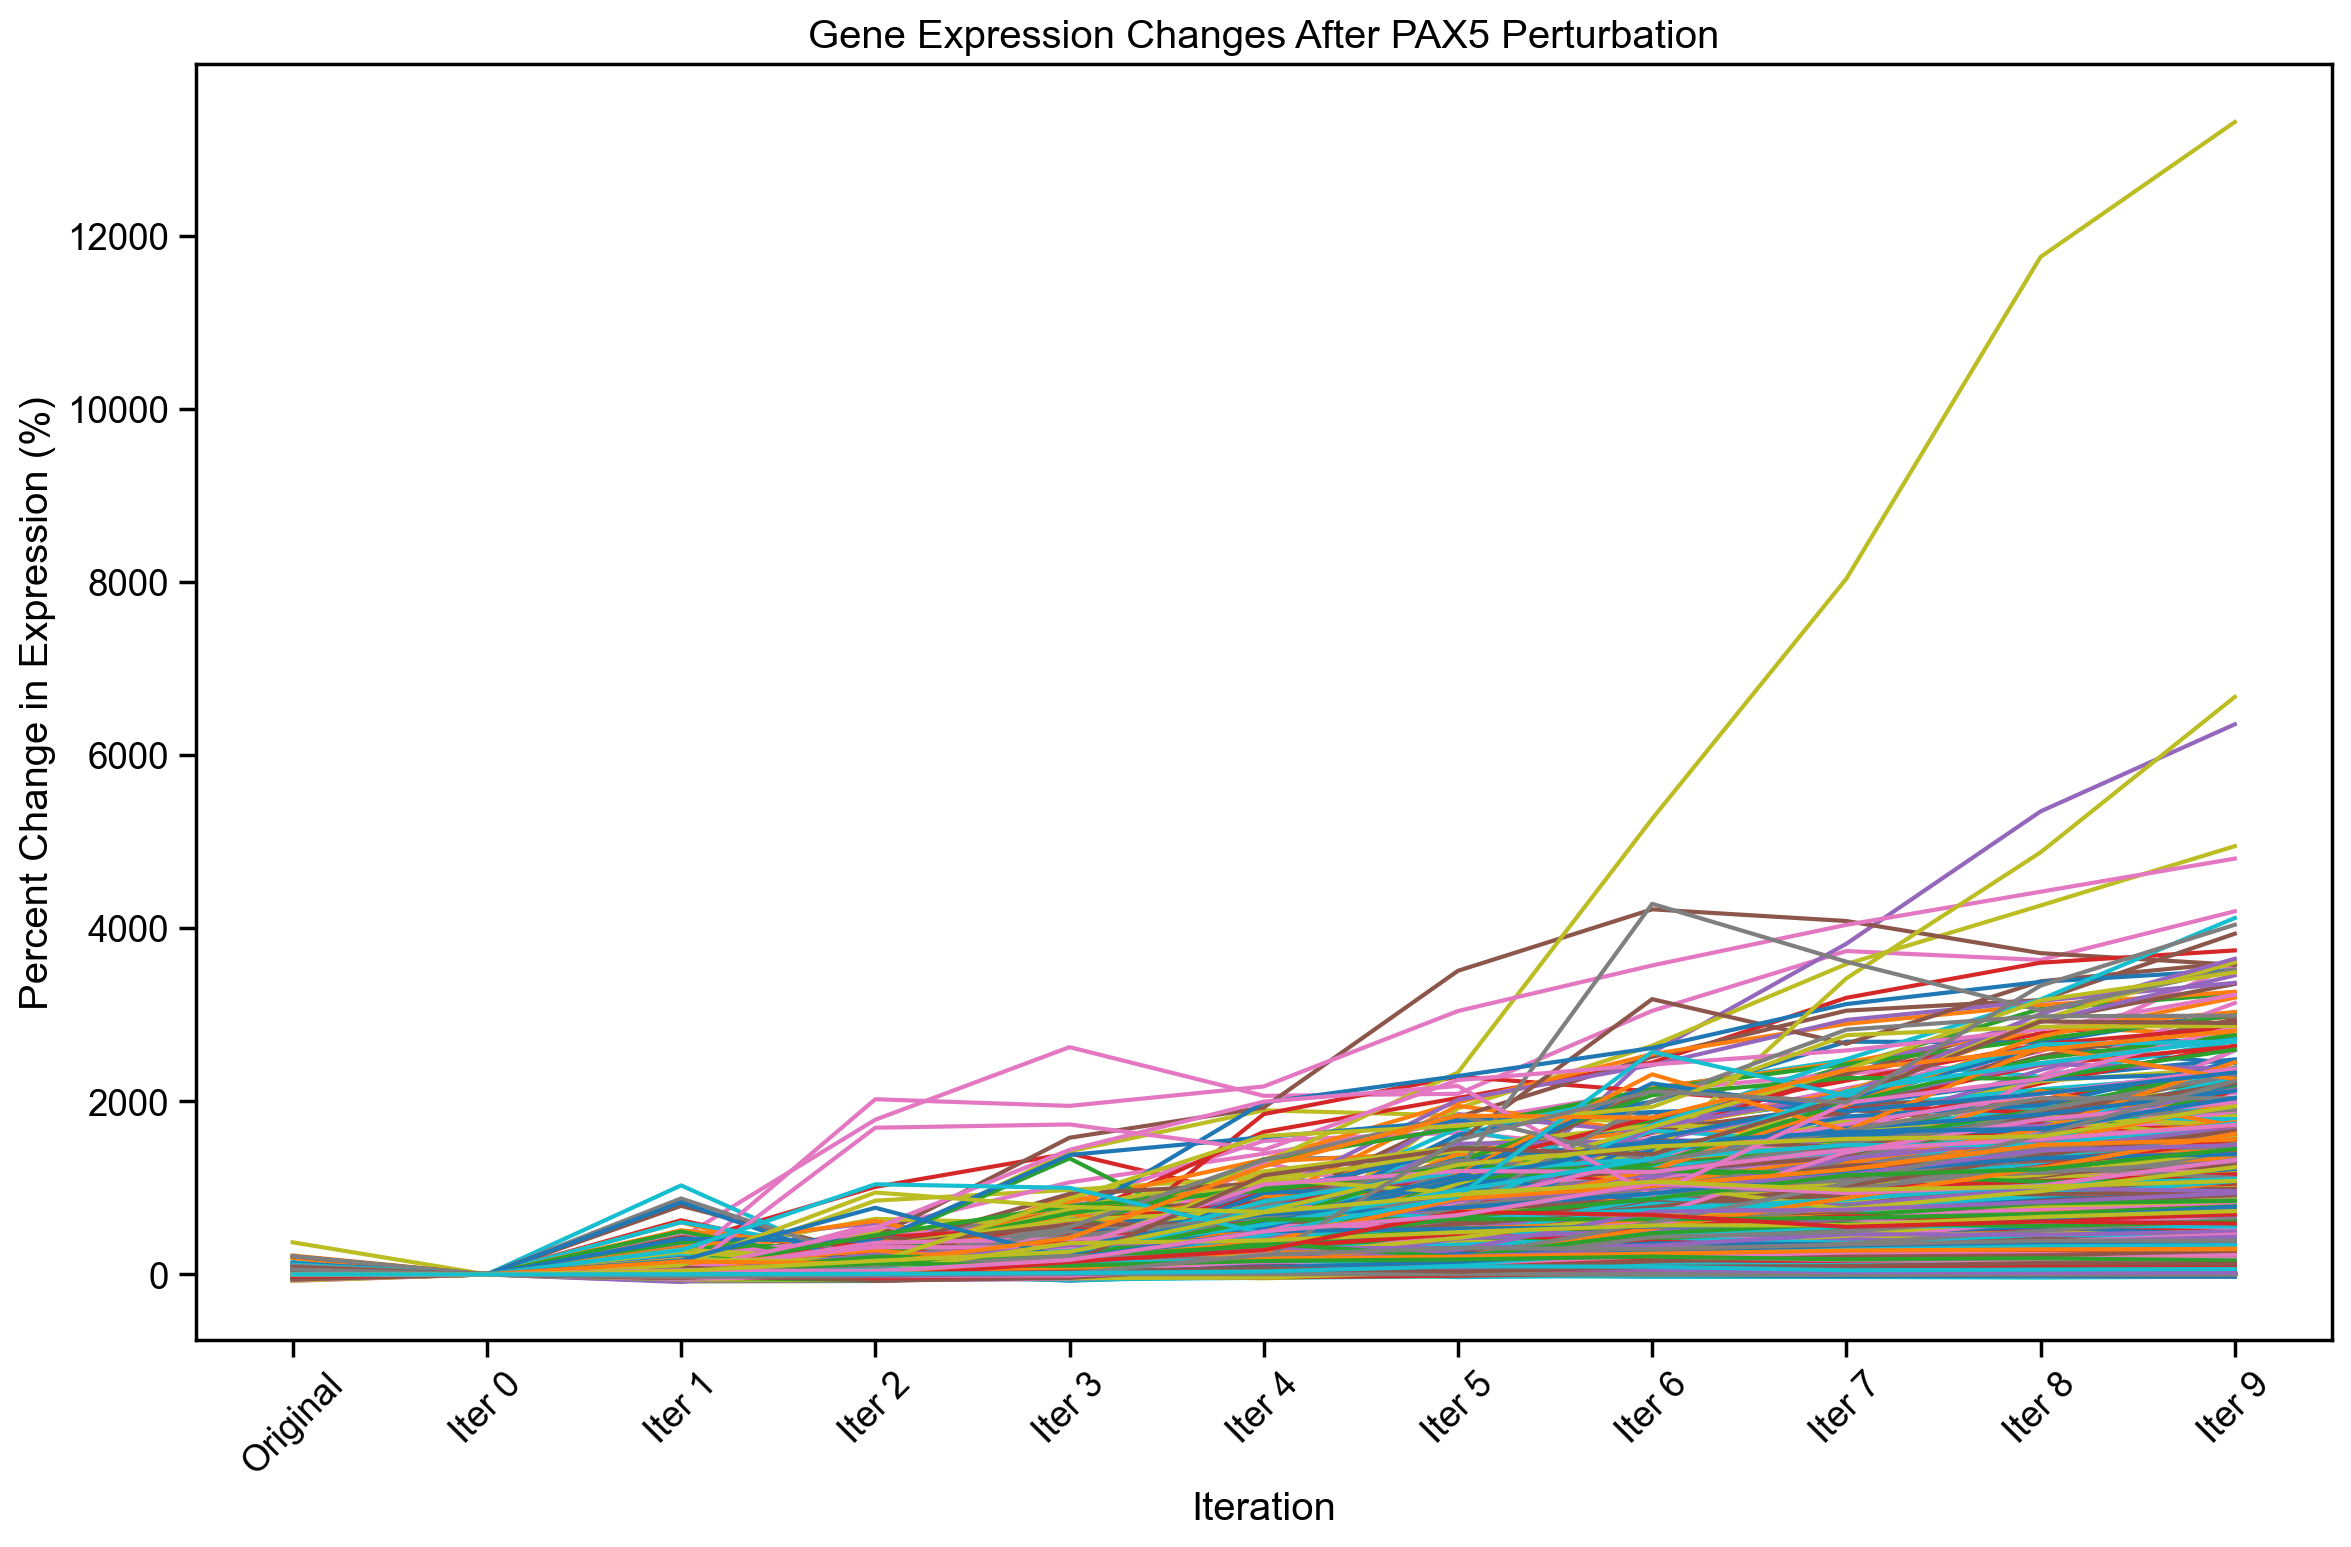

In [77]:
all_genes = list(pythia.adata.var_names)
random_genes = random.sample(all_genes, 1000)
plot_gene_expression_after_perturbation(random_genes, percent_change=True)

In [79]:
pythia.adata.to_df()

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'PAX5_10n_0x', 'PAX5_iter_0', 'PAX5_iter_1', 'PAX5_iter_2', 'PAX5_iter_3', 'PAX5_iter_4', 'PAX5_iter_5', 'PAX5_iter_6', 'PAX5_iter_7', 'PAX5_iter_8', 'PAX5_iter_9'
    obsp: 'connectivities', 'distances'

In [5]:
# Check betadatas contain no NaNs

from tqdm import tqdm

for key in tqdm(pythia.beta_dict.data.keys()):
    assert pythia.beta_dict.data[key].isnull().sum().sum() == 0

In [ ]:
genes = ['GATA3', 'PAX5', 'STAT1', 'STAT4']
set(genes) & set(adata_train.var_names)

{'GATA3', 'PAX5', 'STAT1', 'STAT4'}

In [85]:
pythia.perturb_batch(
    target_genes=genes, 
    n_propagation=3, 
    gene_expr=0, 
    save_to='/ix/djishnu/shared/djishnu_kor11/perturbations/snrna_human_tonsil'
)

In [4]:
xy = pd.DataFrame(pythia.adata.obsm['spatial'], columns=['x', 'y'], index=pythia.adata.obs_names)


In [14]:
# plt.rcParams['figure.figsize'] = [6, 6]
# plt.rcParams['figure.dpi'] = 180

# sns.scatterplot(
#     data = xy.join(pythia.adata.obs),
#     x='x', y='y', 
#     hue='cell_type',
#     palette='tab20',
#     s=20
# )

# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.gca().set_xticklabels([])
# plt.gca().set_yticklabels([])
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.legend(bbox_to_anchor=(0.5, -0.1), 
#            loc='upper center', ncol=4, frameon=False)
# plt.xlabel('')
# plt.ylabel('')
# plt.show()


In [4]:
import commot as ct

from spaceoracle.tools.network import expand_paired_interactions
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

lr = expand_paired_interactions(df_ligrec)

In [5]:
lr = lr[lr.ligand.isin(pythia.adata.var_names) & lr.receptor.isin(pythia.adata.var_names)]

In [ ]:
pythia.queue

OracleQueue with 0 remaining genes

In [7]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl',
    organism='human',
    annot='cell_type_int'
)

In [ ]:
pythia.compute_betas()

100%|██████████| 3413/3413 [00:34<00:00, 98.47it/s] 


In [9]:
goi = 'IL7'

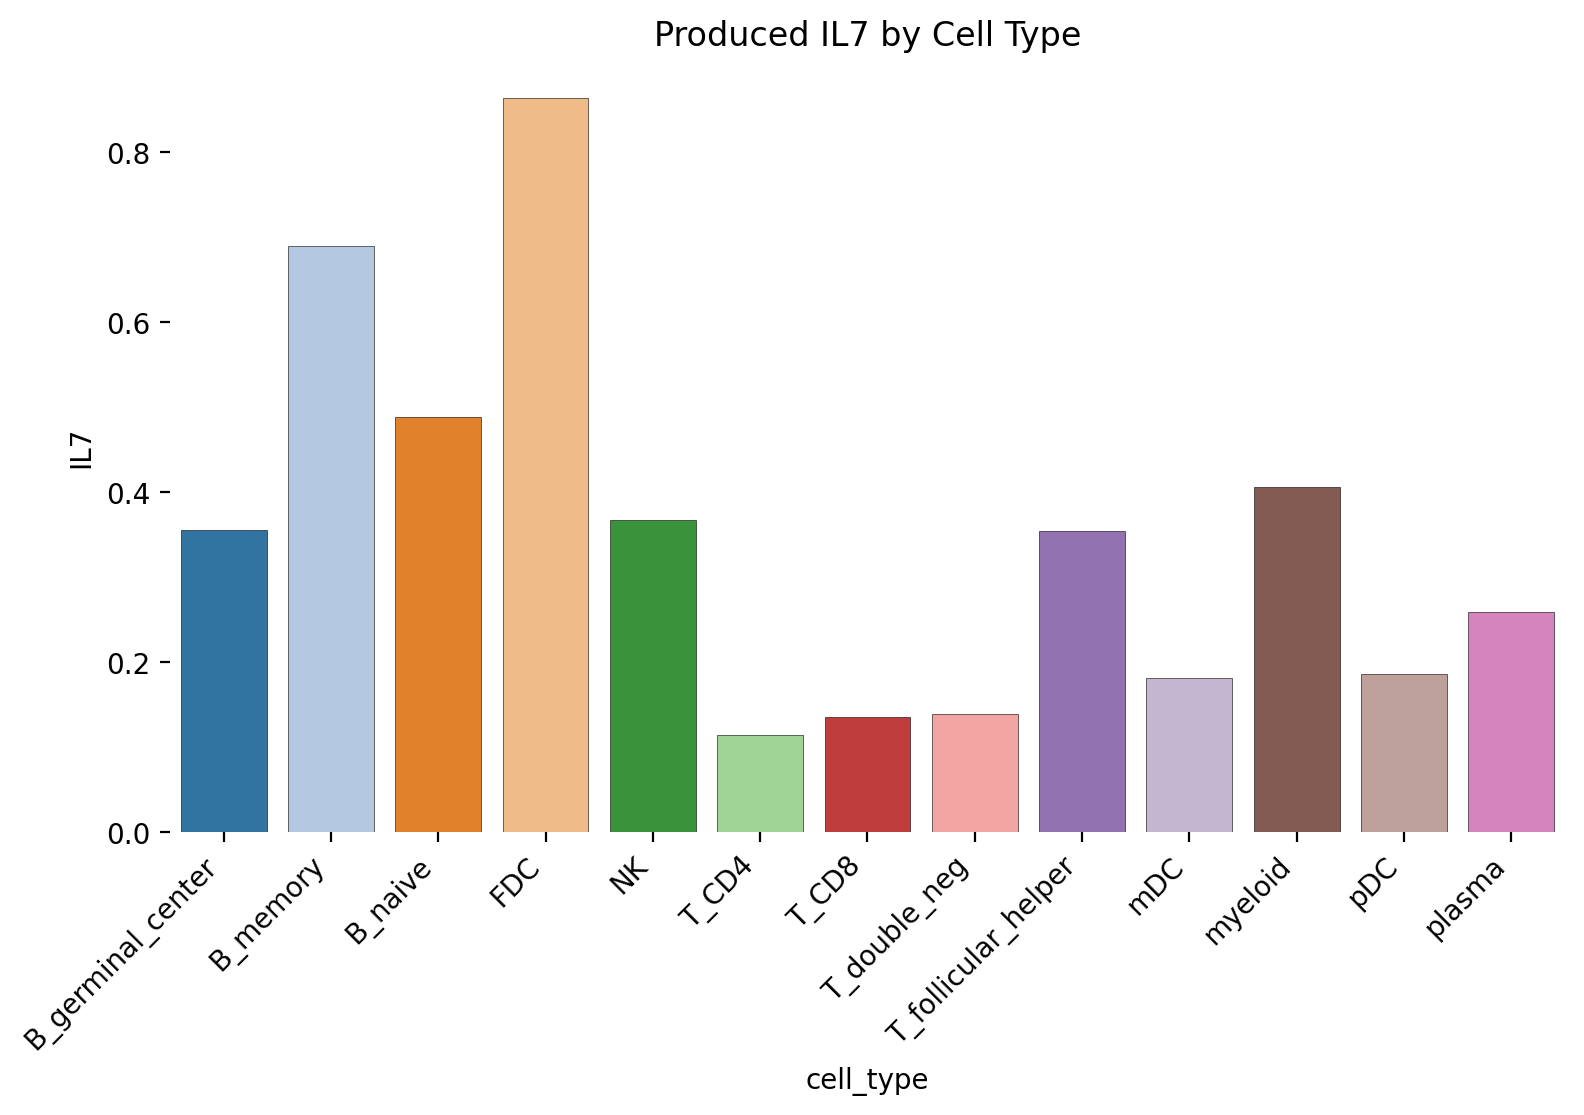

In [ ]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.dpi'] = 100

xy = pd.DataFrame(pythia.adata.obsm['spatial'], columns=['x', 'y'], index=pythia.adata.obs_names)
sns.barplot(
    data=pythia.adata.to_df(layer='imputed_count').join(xy).join(
        pythia.adata.obs['cell_type']).groupby(
            'cell_type')[goi].mean().reset_index(),
    x='cell_type',
    y=goi,
    linewidth=0.2,
    edgecolor='black',
    palette='tab20'
)
plt.xticks(rotation=45, ha='right')
plt.title(f'Produced {goi} by Cell Type')
plt.box(False)
plt.show()

In [ ]:
# cells = list(
#     pythia.adata.obs.reset_index()[
#         pythia.adata.obs.reset_index()['cell_type'].isin(
#             ['T_follicular_helper']
#         )].index)

cell_idx = xy[
    (xy.x > 2000) & (xy.y < 1500)].join(
    pythia.adata.obs['cell_type']).query('cell_type=="FDC"').index

cells = pythia.adata.obs.reset_index()[pythia.adata.obs.reset_index()['NAME'].isin(cell_idx)].index.tolist()

# cells = pythia.adata.obs.reset_index().index.tolist()
len(cells), len(adata_train.obs)

(34, 5778)

View of AnnData object with n_obs × n_vars = 34 × 3540
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count'

In [ ]:
# sns.scatterplot(
#     data=xy.join(pythia.adata[:, :].obs),
#     x='x', y='y', c='grey'
# )

# sns.scatterplot(
#     data=xy.join(pythia.adata[cells, :].obs),
#     x='x', y='y', hue='cell_type'
# )

In [21]:
goi

'IL7'

Running simulation 3/3: 100%|██████████| 5778/5778 [07:15<00:00, 13.28it/s]


In [ ]:
# plt.rcParams['figure.figsize'] = (8, 8)
# plt.rcParams['figure.dpi'] = 120

# s = 25
# sns.scatterplot(
#     x='x', y='y', 
#     data=xy.join(pythia.adata.obs['cell_type']).query('cell_type!="FDC"'), 
#     s=s,
#     color='grey',
#     alpha=0.5,
#     legend=False,
#     label='Other Cells'
# )

# sns.scatterplot(
#     x='x', y='y', 
#     data=xy.join(pythia.adata.obs['cell_type']).query('cell_type=="FDC"'), 
#     color='orange',
#     linewidth=0.2,
#     edgecolor='black',
#     s=s+15,
#     alpha=0.5, 
#     legend=False,
#     label='FDC Cells'
# )

# sns.scatterplot(
#     x='x', y='y', 
#     data=xy.join(pythia.adata.obs['cell_type']).iloc[cells], 
#     color='red',
#     marker='X',
#     s=s,
#     alpha=0.5, 
#     legend=False,
#     label='knockout targets'
# )
# plt.legend()
# plt.gca().set_axis_off()
# plt.show()

In [28]:
pythia.adata.to_df(layer='delta_X').mean().sort_values(ascending=False)

Unnamed: 0
EBF1      0.000626
H2AFZ     0.000281
FDCSP     0.000279
RHEX      0.000250
CLU       0.000246
            ...   
SKAP1    -0.000266
LHFPL2   -0.000279
CAMK4    -0.000281
FOXP1    -0.000290
IL7      -0.004836
Length: 3540, dtype: float64

In [ ]:
pythia.adata.obs = pythia.adata.obs.join(pd.read_csv('/tmp/banksy_celltypes.csv', index_col=0))

In [38]:
pythia.adata.obs.cell_type.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [77]:
color_dict = {
    'T_CD4': "#ea7465",
    'T_follicular_helper': "#b74329", 
    'T_CD8': "#dd3652",
    
    'GC Light Zone': "#5bbbdb",
    'GC Intermediate Zone': "#5bbbdb",
    'GC Dark Zone': "#5bbbdb",
    
    'B_memory': "#61c17c",
    'B_naive': "#4b9131", 
    'plasma': "#beb637",
    
    'mDC/myeloid': "#c6ccc2",
    'FDC': "#79949a",
    'pDC': "#98907f"
}

In [1]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['figure.dpi'] = 100

# Create the data first
plot_data = pythia.adata.to_df(layer='delta_X').join(xy).join(
    pythia.adata.obs['cell_type']).query('cell_type=="B_germinal_center"')
foxp1_values = plot_data['FOXP1']

# Create scatter plot
g = sns.scatterplot(
    data=plot_data,
    x='x', y='y',
    hue='FOXP1',
    palette='magma', 
    linewidth=0.2,
    legend=False,
    edgecolor='black',
    s=40
)

# Create colorbar using the actual data values
norm = plt.Normalize(foxp1_values.min(), foxp1_values.max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
plt.colorbar(sm, ax=g)

NameError: name 'plt' is not defined